# reconstruct the effective energy shift

Compute the effective energy shifts from the reconstructed R-correlator
\begin{equation}
R = \sum b_n e^{-\Delta E_n t}
\end{equation}

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle
import os

In [4]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit
m_red = 0.5 * mxi # reduced mass

In [5]:
bin_num = 20 # number of jackknife samples

load contamination factors, which is generated 
in "R-corr. decomposition.ipynb"

In [6]:
with open('pickles/an_bn_and_eigen.pkl', 'rb') as fin:
    an_jk, bn_jk, eigenvals = pickle.load(fin)

In [7]:
# uncertainties is a useful python library to calculate the propagation of the errors
# pip install uncertainties 
from uncertainties import ufloat

In [8]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import original data

In [9]:
with open('../data/dEeff_xixi_1s0.pkl', 'rb') as fin:
    dEeffs = pickle.load(fin)

keys of dEeffs are (L, src)

In [10]:
dEeffs.keys()

dict_keys([(40, 'wall'), (48, 'wall'), (64, 'wall'), (40, 'exp'), (48, 'exp'), (64, 'exp')])

In [11]:
dEeffs[(40, 'wall')].shape

(23, 5)

1. t 
2. average of the Rcorr
3. error of the Rcorr
4. average of the effective energy shift
5. error of the effective energy shift

test plot of the effective energy shifts

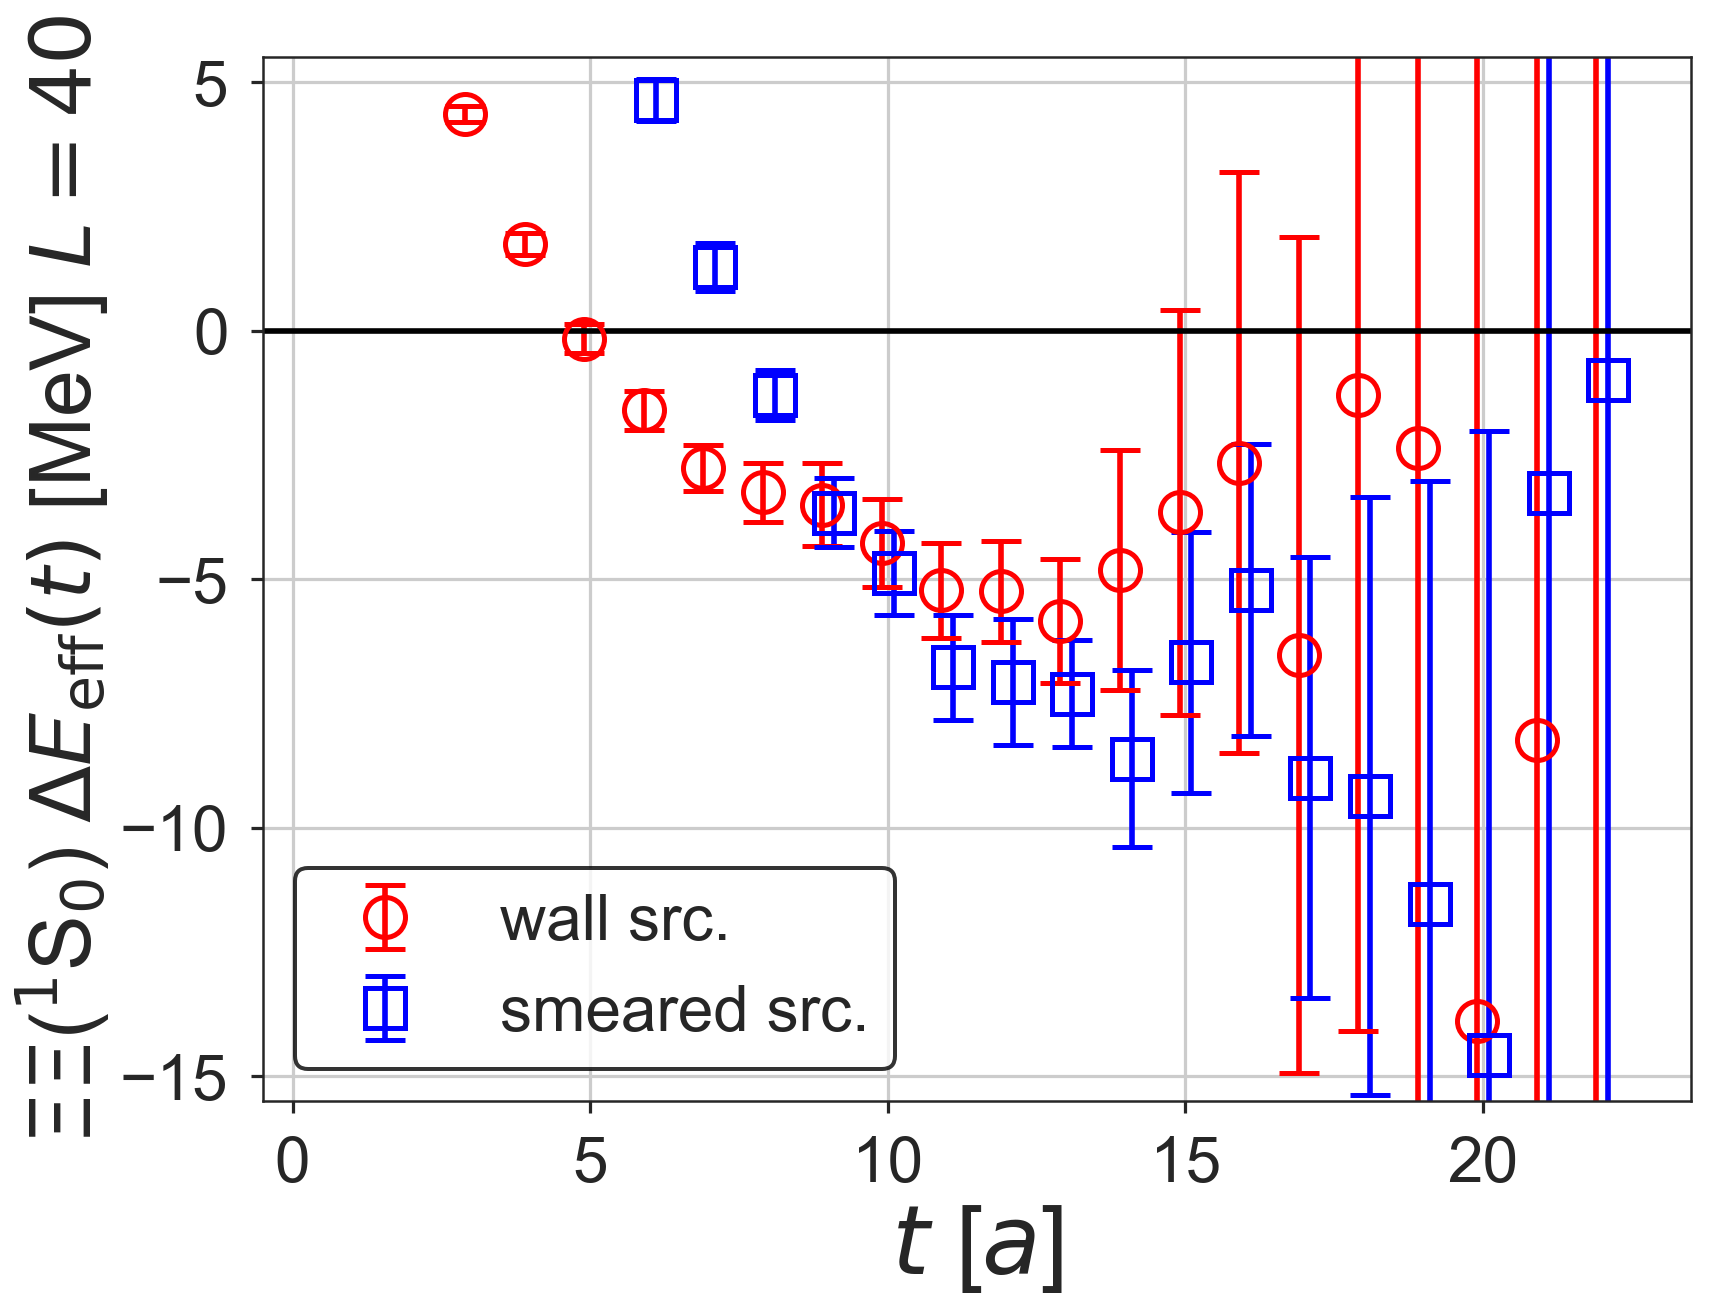

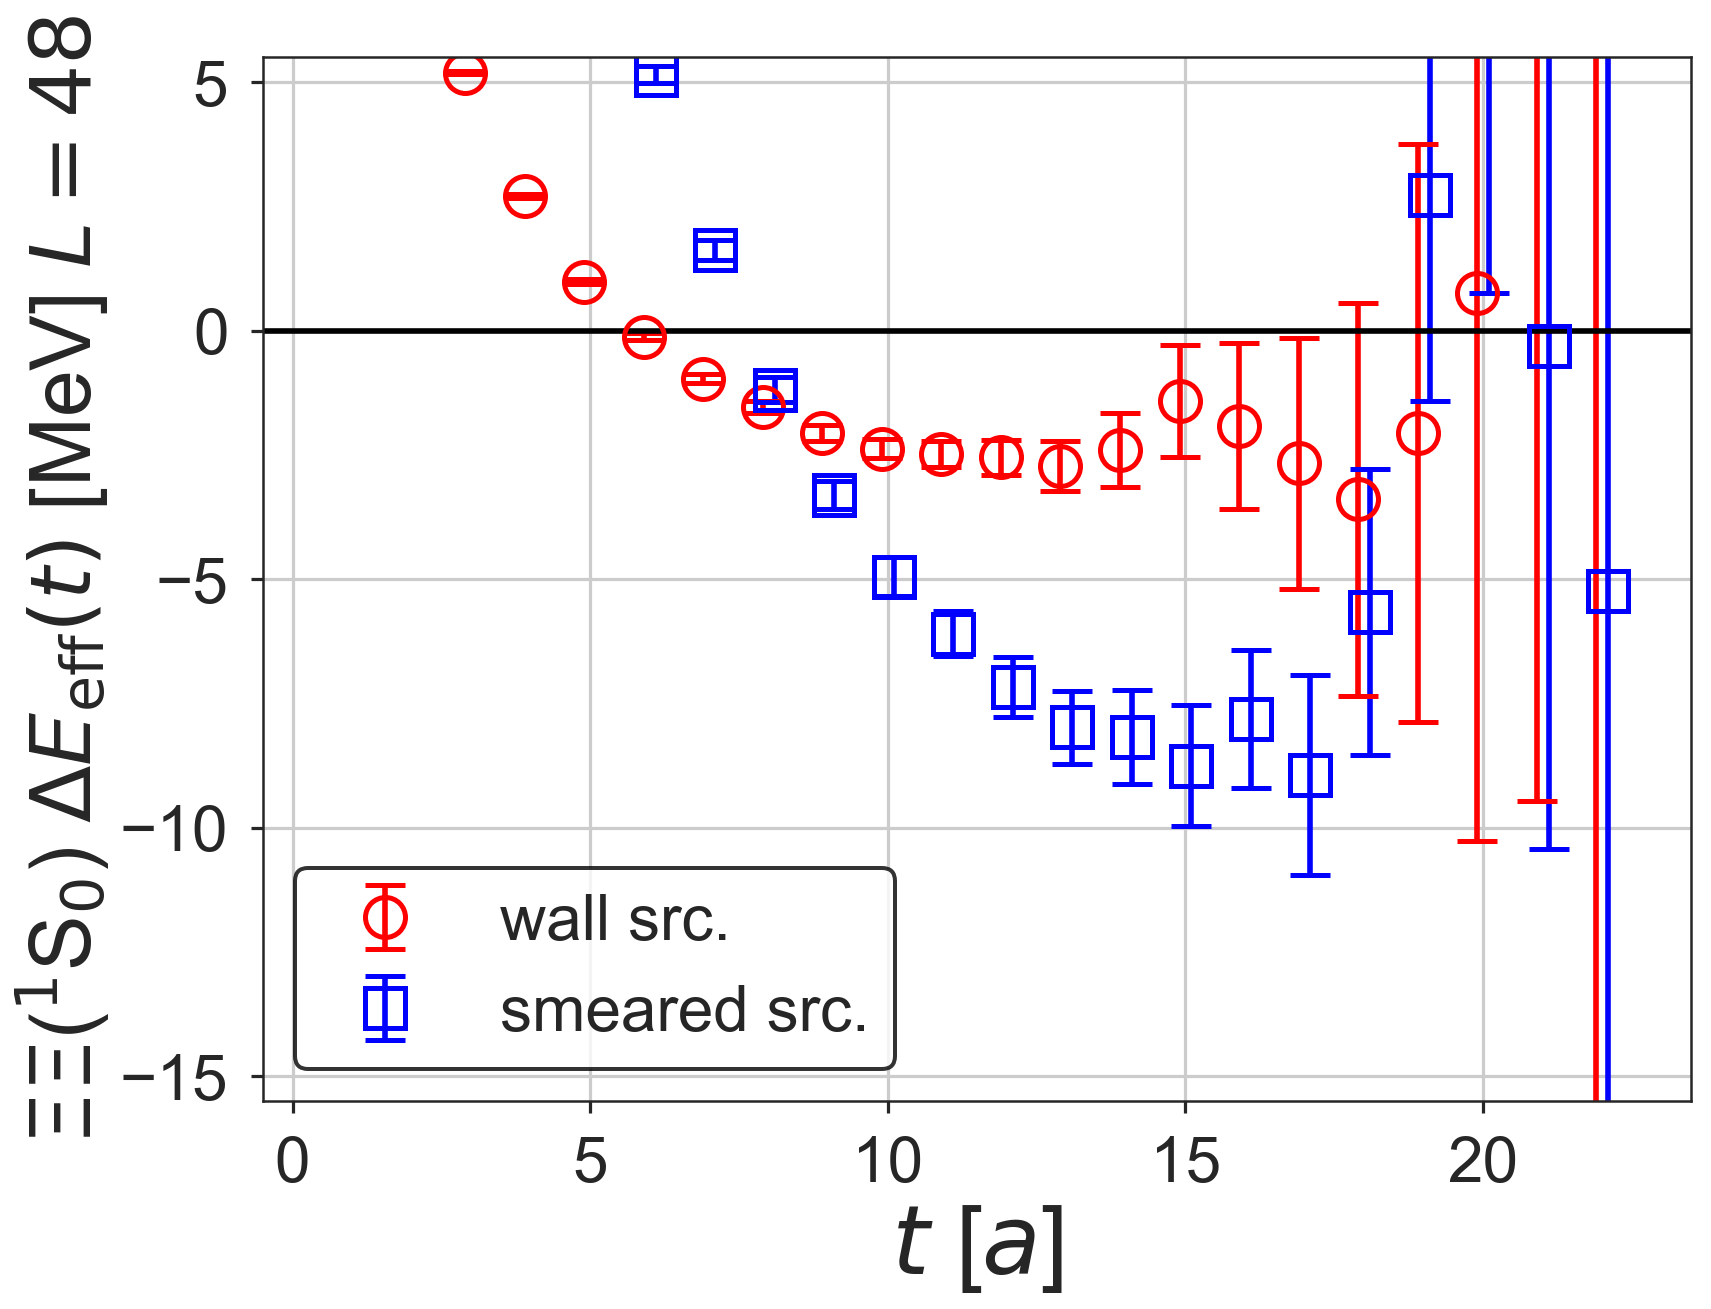

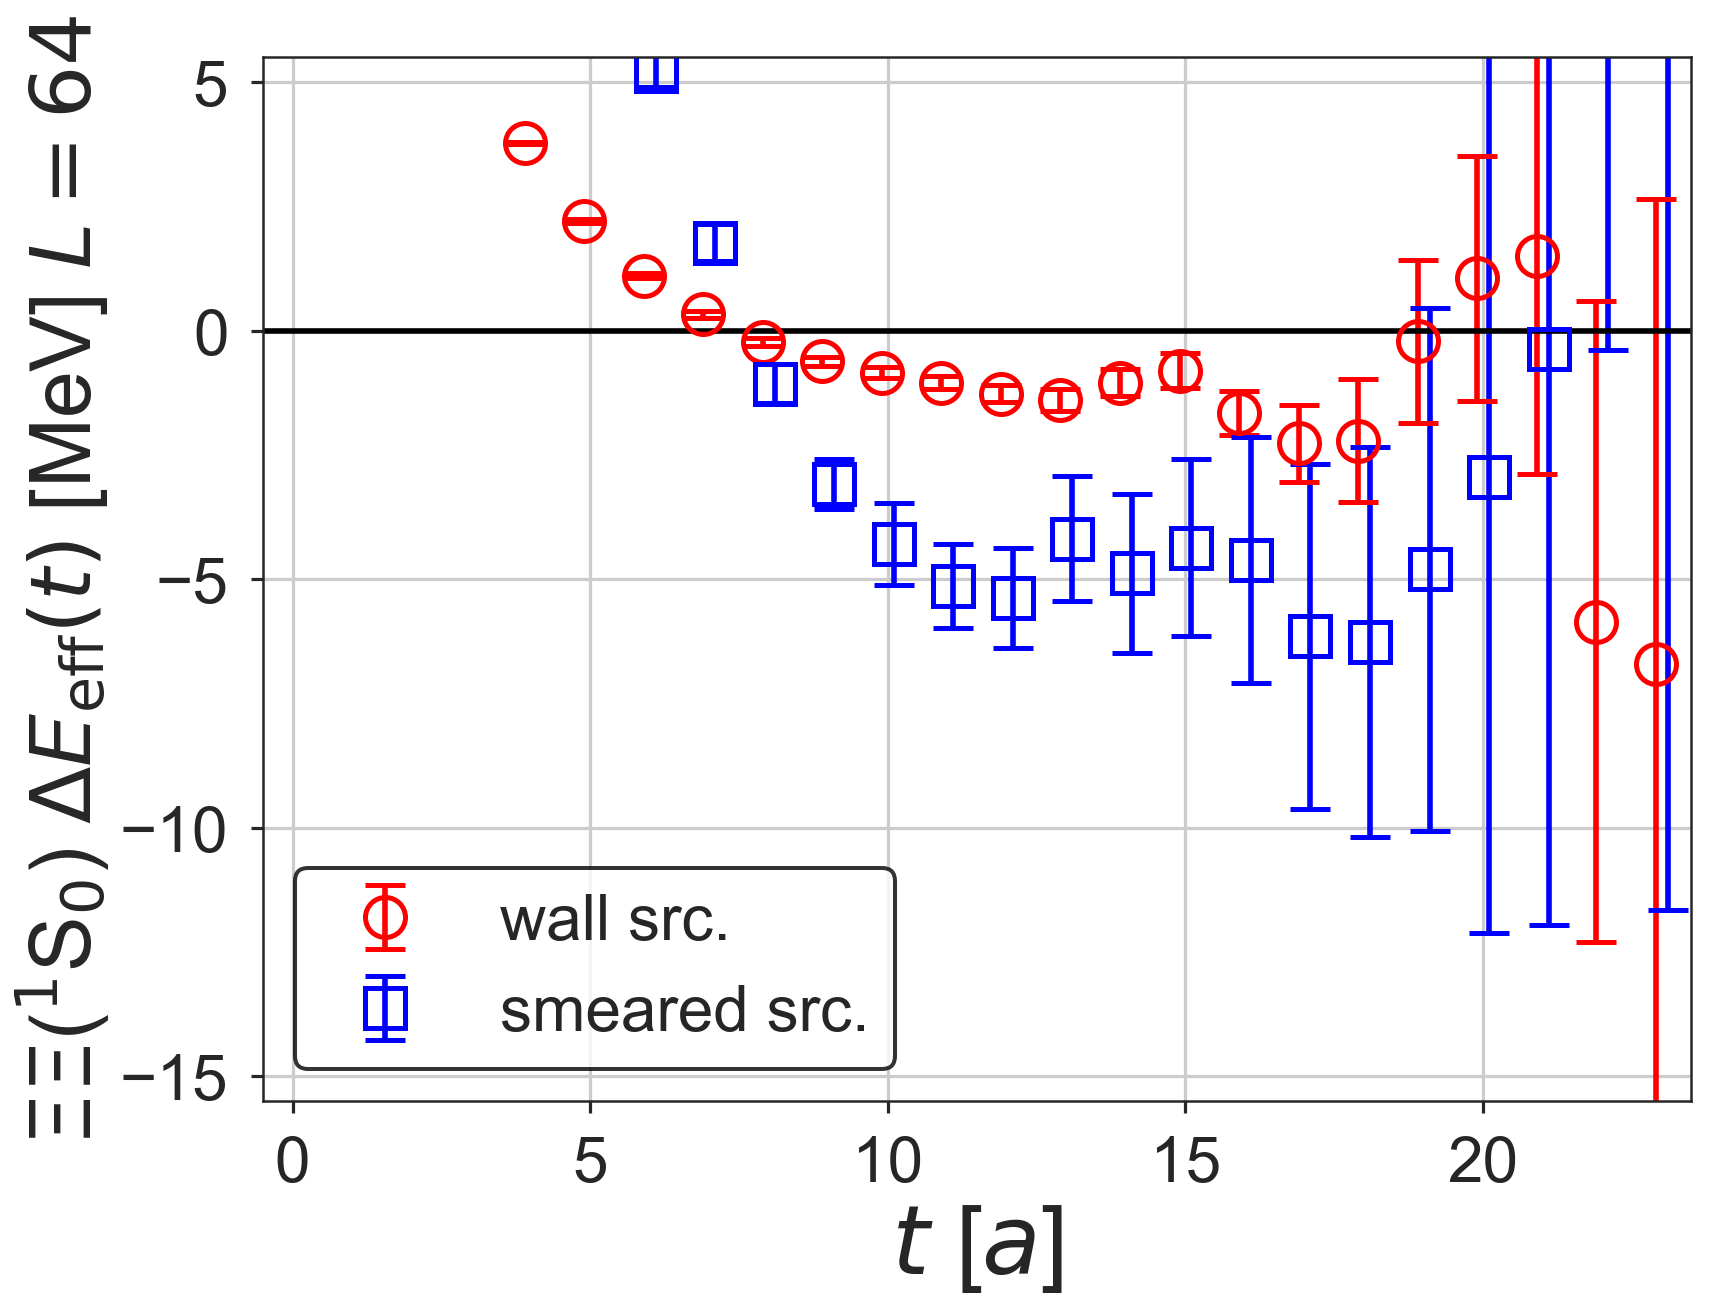

In [12]:
for L in [40, 48, 64]:
    fig, ax = plt.subplots()
    ax.errorbar(dEeffs[(L,'wall')][:,0]-0.1, dEeffs[(L,'wall')][:,3]*ainv, dEeffs[(L,'wall')][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    ax.errorbar(dEeffs[(L,'exp')][:,0]+0.1, dEeffs[(L,'exp')][:,3]*ainv, dEeffs[(L,'exp')][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='lower left', frameon=True)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'$\Xi\Xi$($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
#    fig.savefig(f'figs/dEeffs/dEeff_wall_vs_smear_{L}.pdf', bbox_inches='tight')


# calculate the reconstructed effective energy shift

In [13]:
def eval_ReEeff(L, src, its, it0=13):
    Rcorr = lambda t, bn, en: np.sum(bn*np.exp(-en*t))
    mask = eigenvals[(L,it0)][0,:]*ainv < 255
    ret_val = []
    _bn_jk = bn_jk[(src,L,it0)][mask,:]
    _eigenval = eigenvals[(L,it0)][:,mask]
    binNum = _eigenval.shape[0]
    for t in its:
        _Eeff_jk = np.array([np.log(Rcorr(t, _bn_jk[:,ibin], _eigenval[ibin,:])
                                    / Rcorr(t+1, _bn_jk[:,ibin], _eigenval[ibin,:])) for ibin in range(binNum)])
        ret_val.append([_Eeff_jk.mean(),
                       _Eeff_jk.std() * np.sqrt(binNum - 1)])
    return np.array(ret_val)

In [14]:
def eval_ReEeff_w_cut(L, src, its, n, it0=13):
    Rcorr = lambda t, bn, en: np.sum(bn*np.exp(-en*t))
    mask = arange(n)
    ret_val = []
    _bn_jk = bn_jk[(src,L,it0)][mask,:]
    _eigenval = eigenvals[(L,it0)][:,mask]
    binNum = _eigenval.shape[0]
    for t in its:
        _Eeff_jk = np.array([np.log(Rcorr(t, _bn_jk[:,ibin], _eigenval[ibin,:])
                                    / Rcorr(t+1, _bn_jk[:,ibin], _eigenval[ibin,:])) for ibin in range(binNum)])
        ret_val.append([_Eeff_jk.mean(),
                       _Eeff_jk.std() * np.sqrt(binNum - 1)])
    return np.array(ret_val)

In [15]:
mkdir -p ../figs/dEeffs

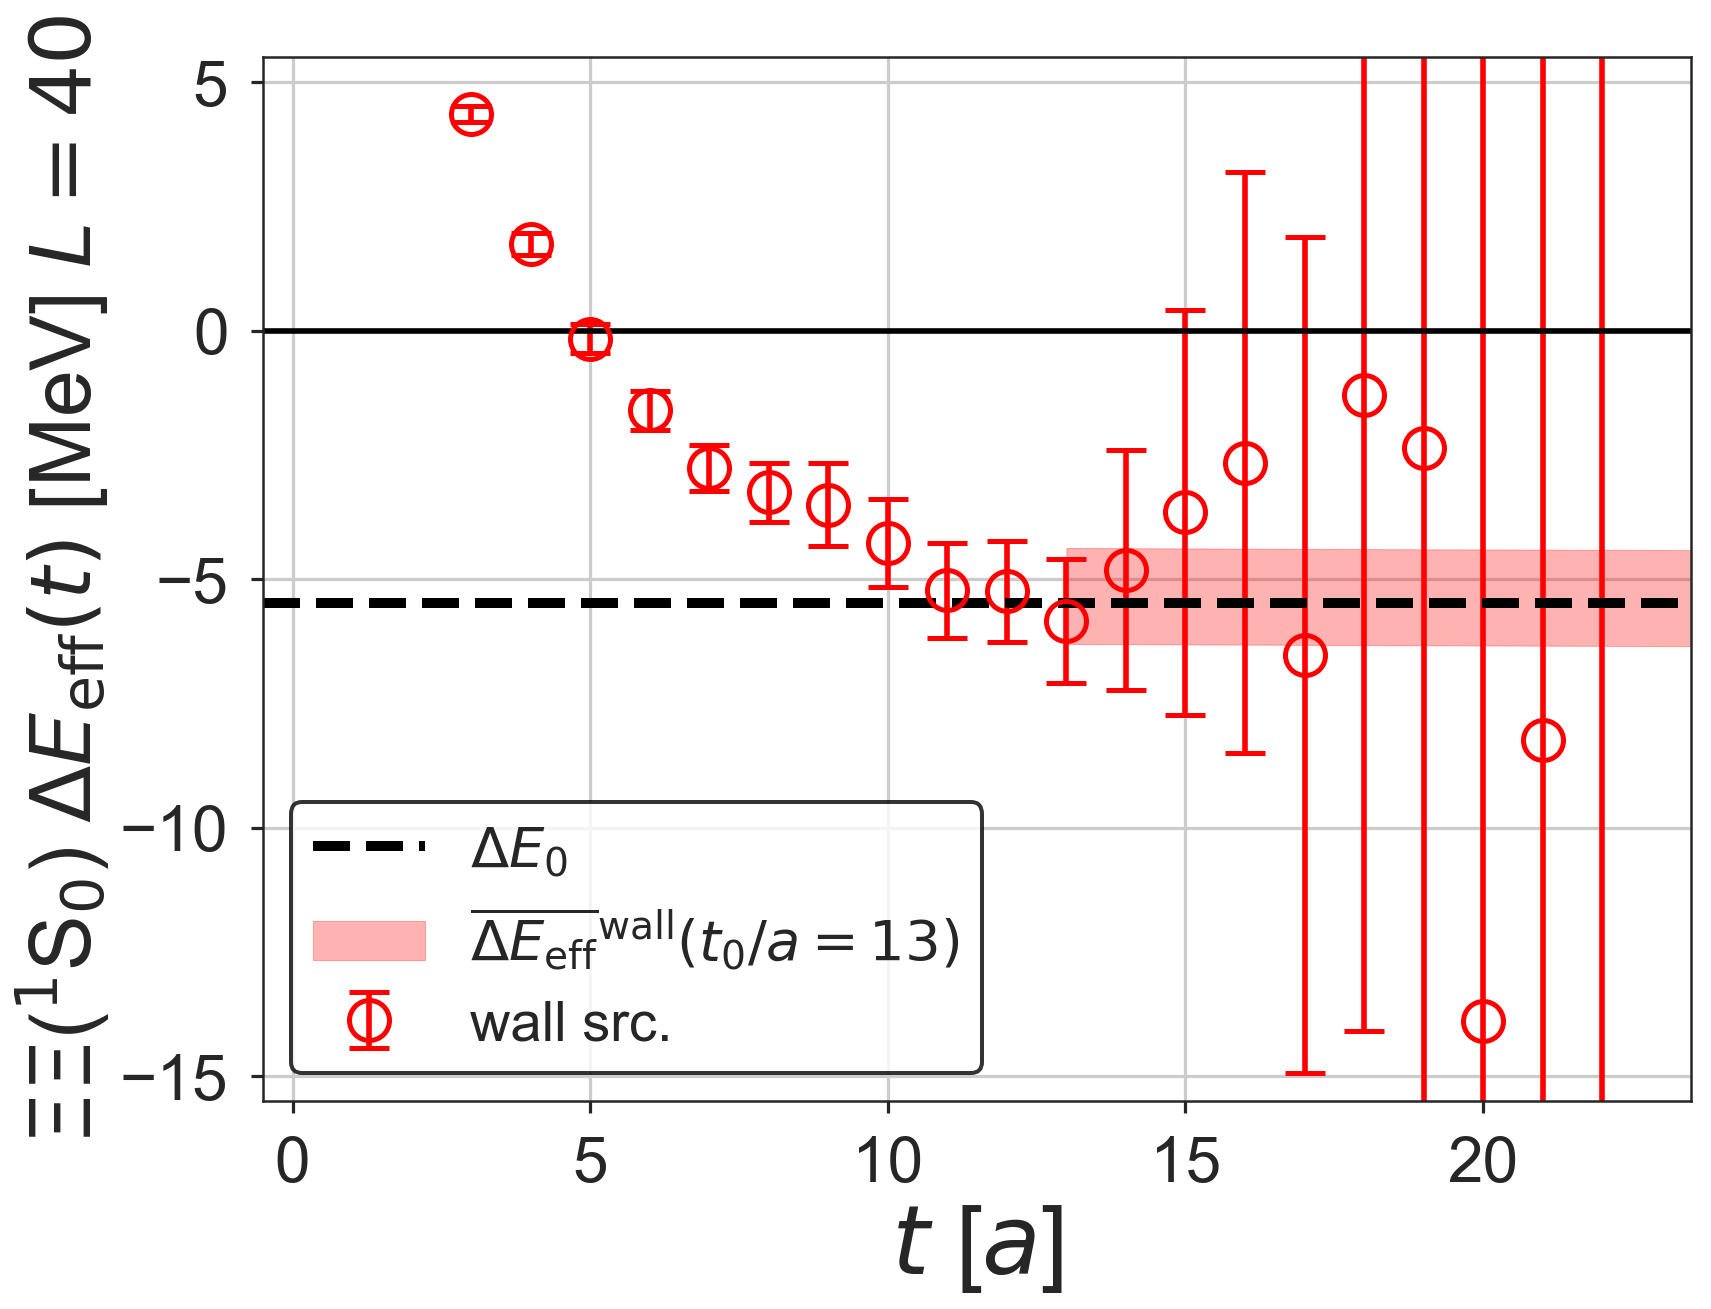

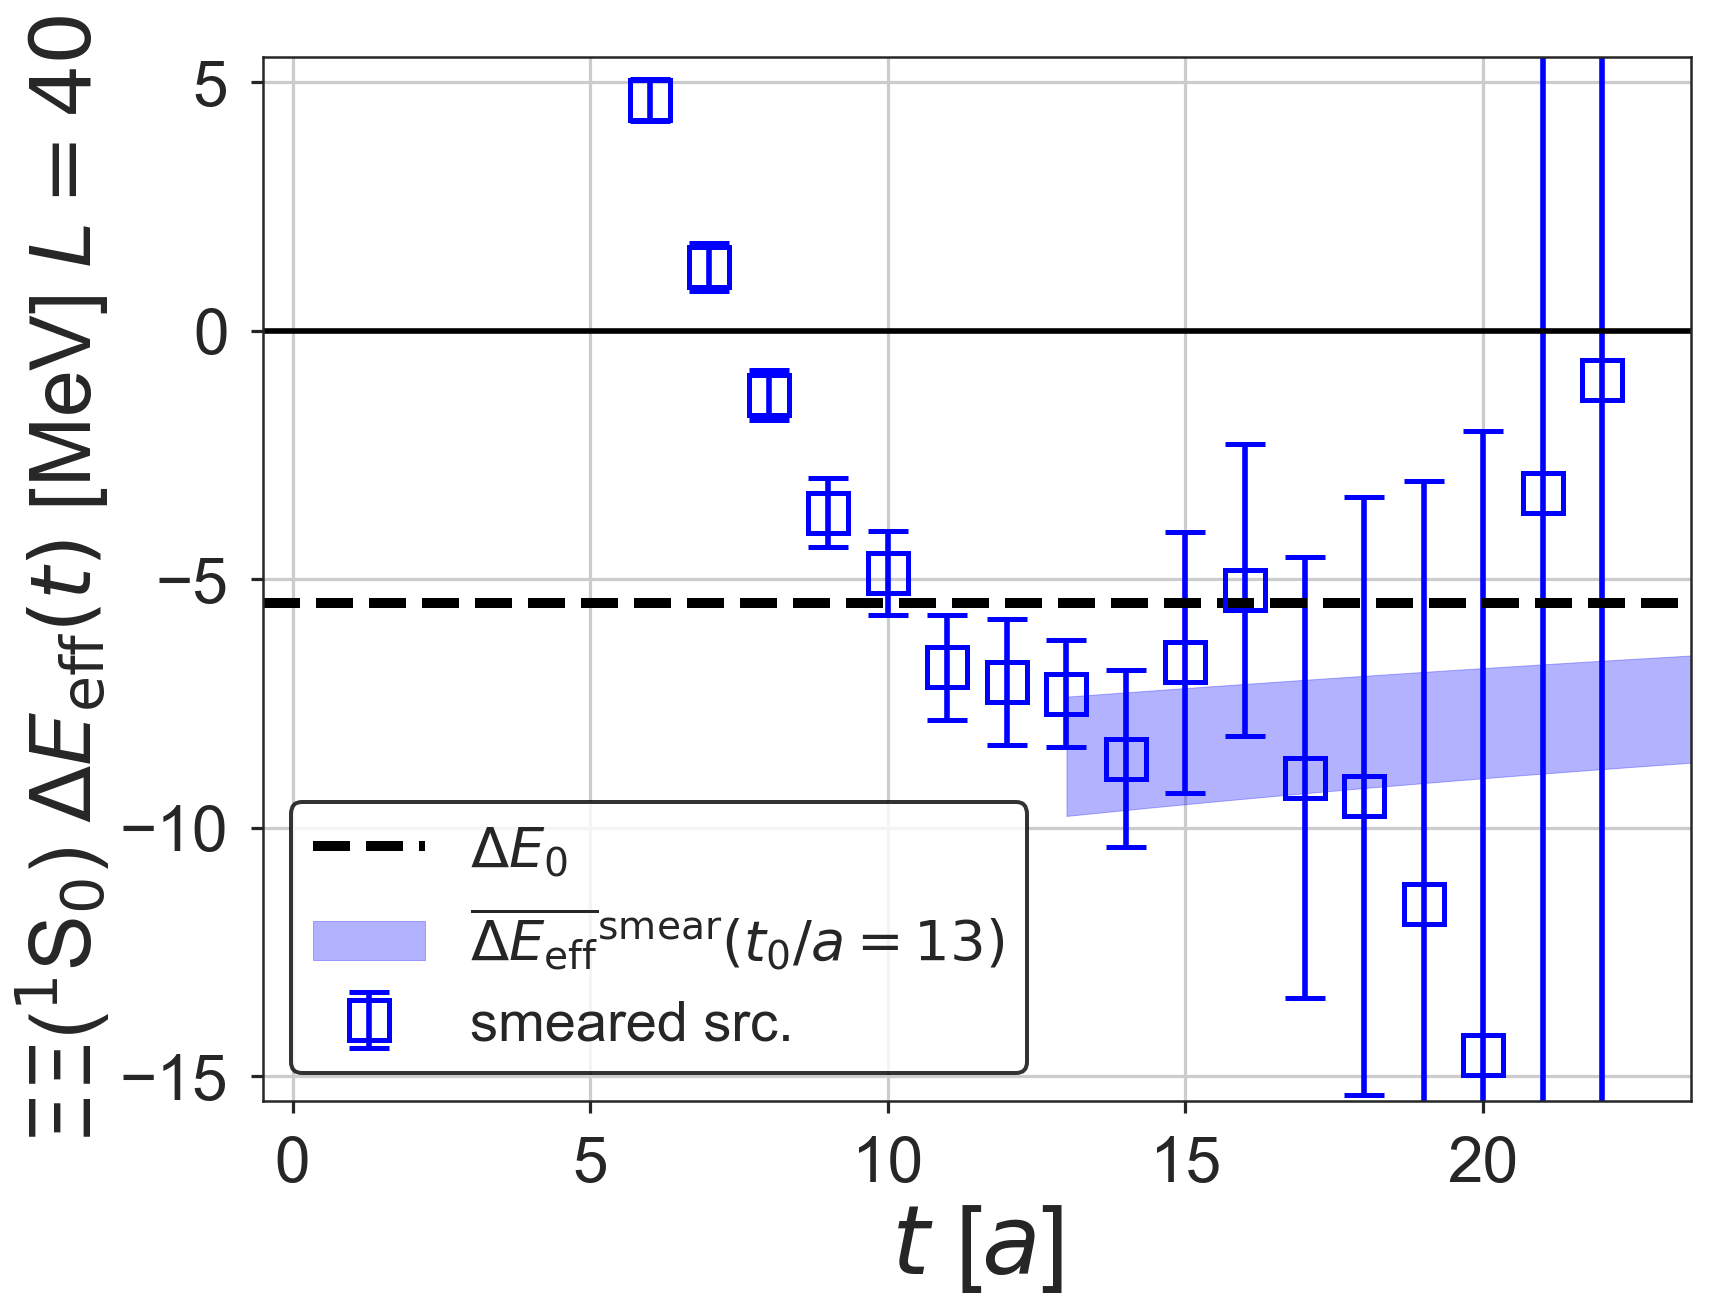

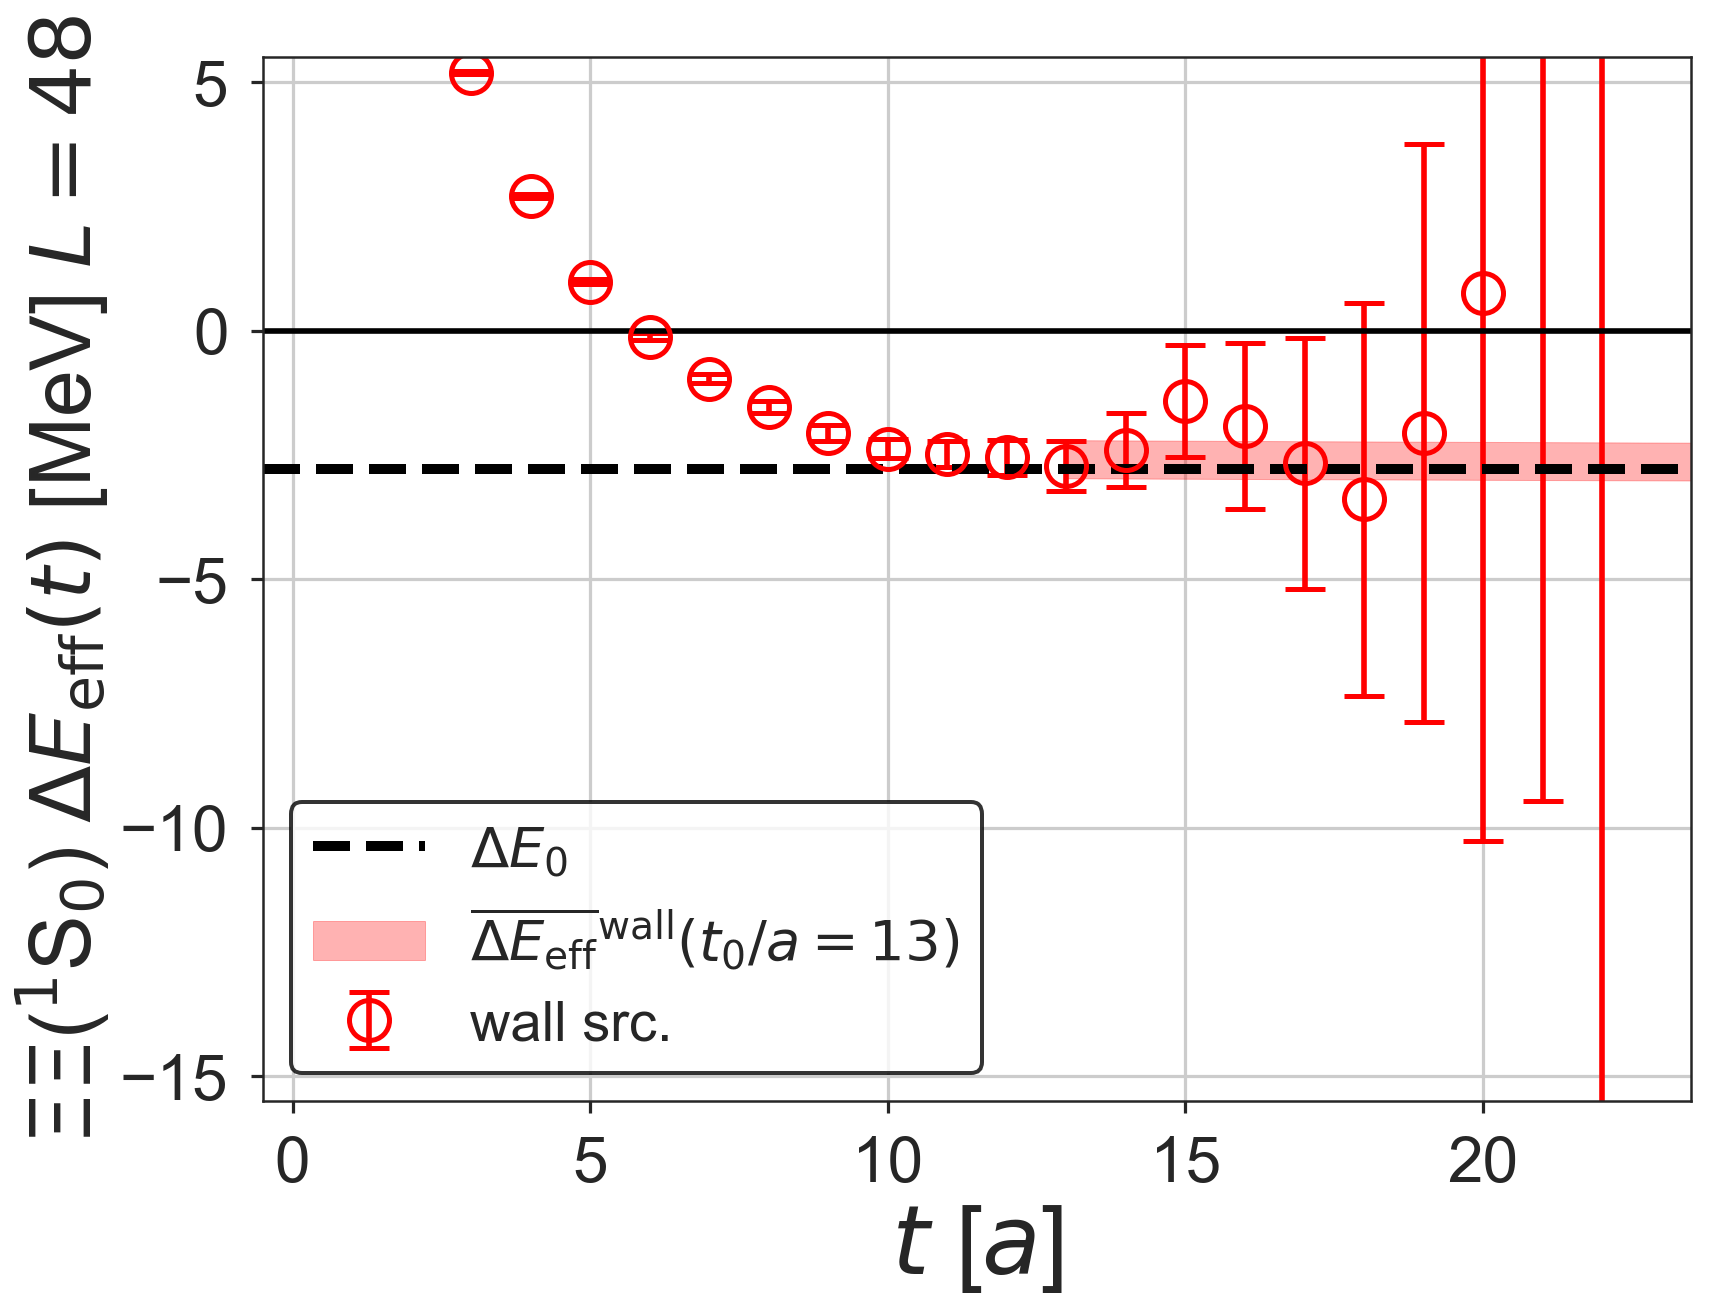

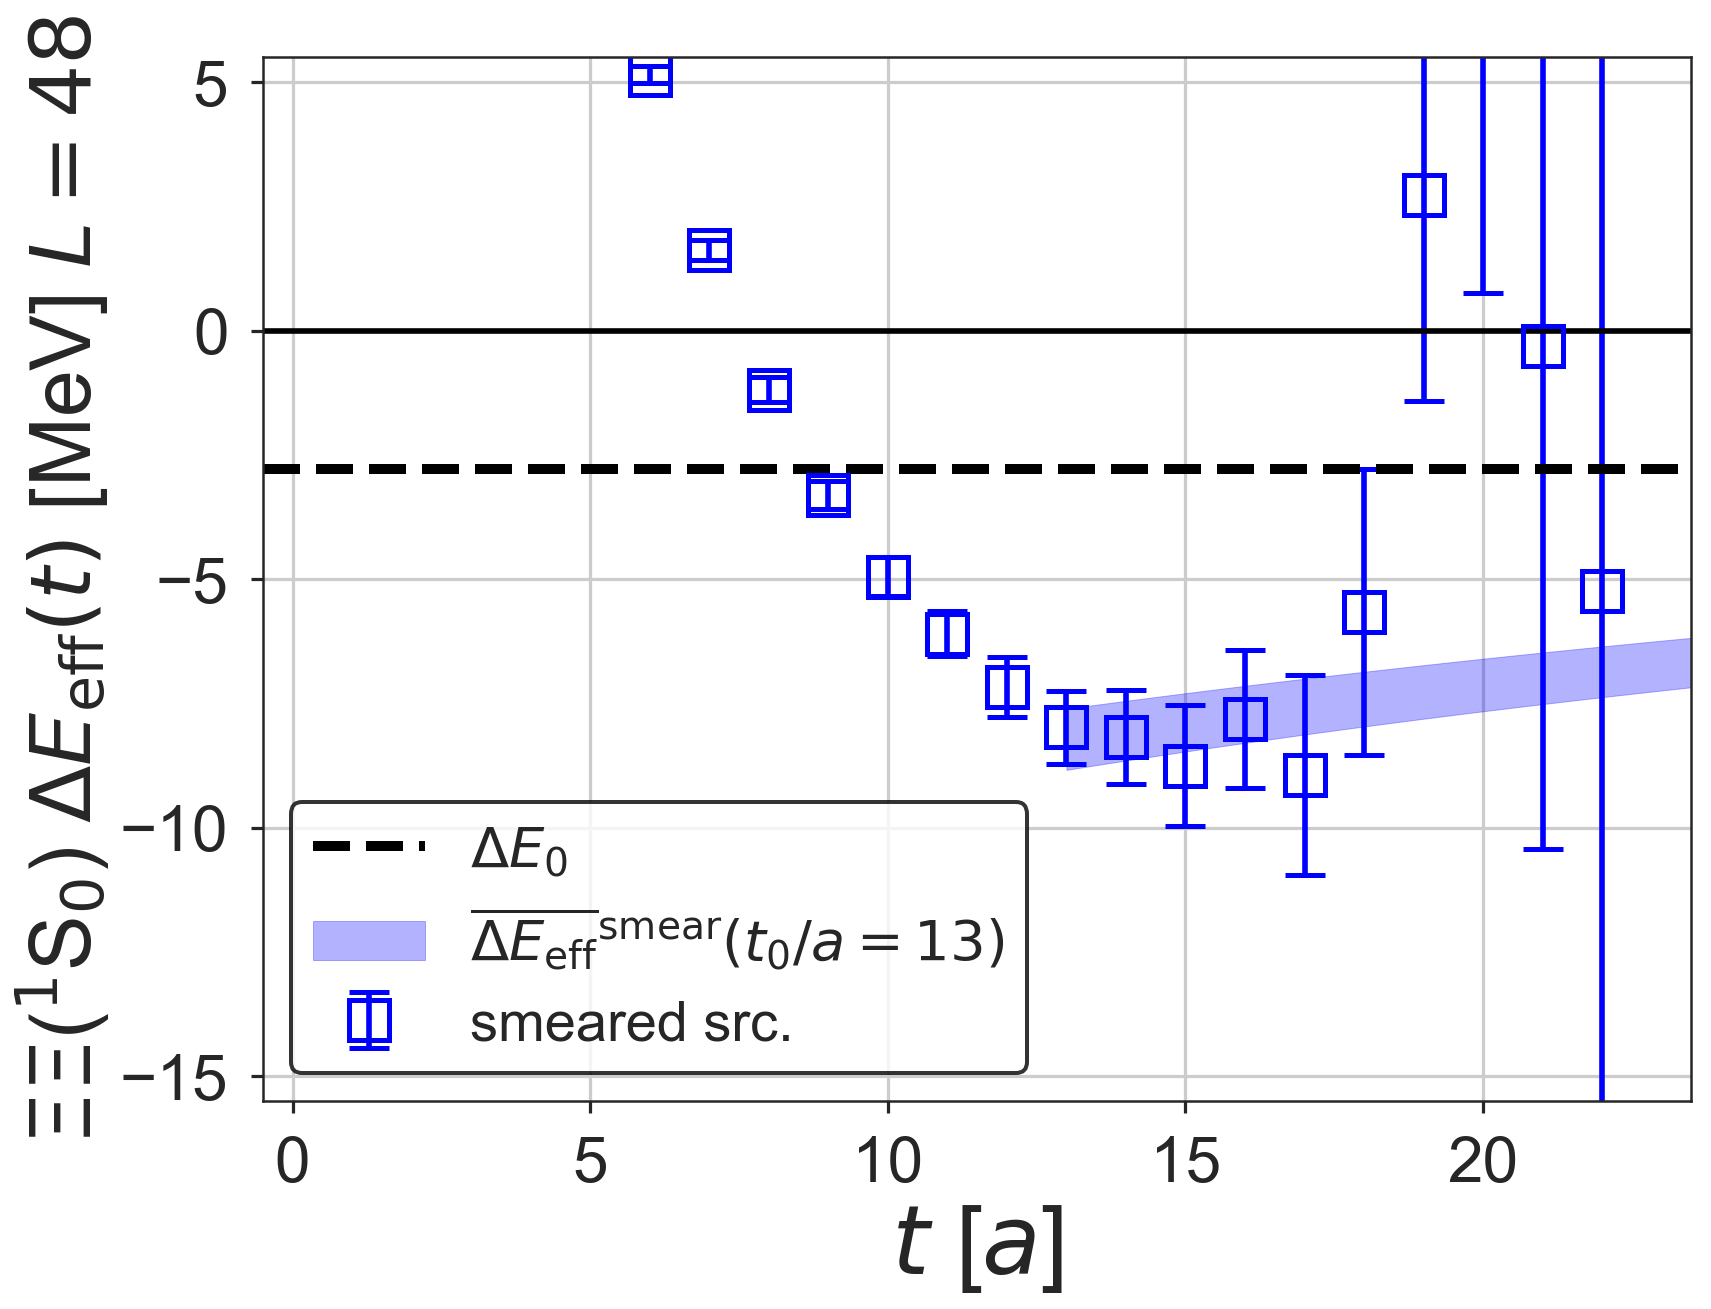

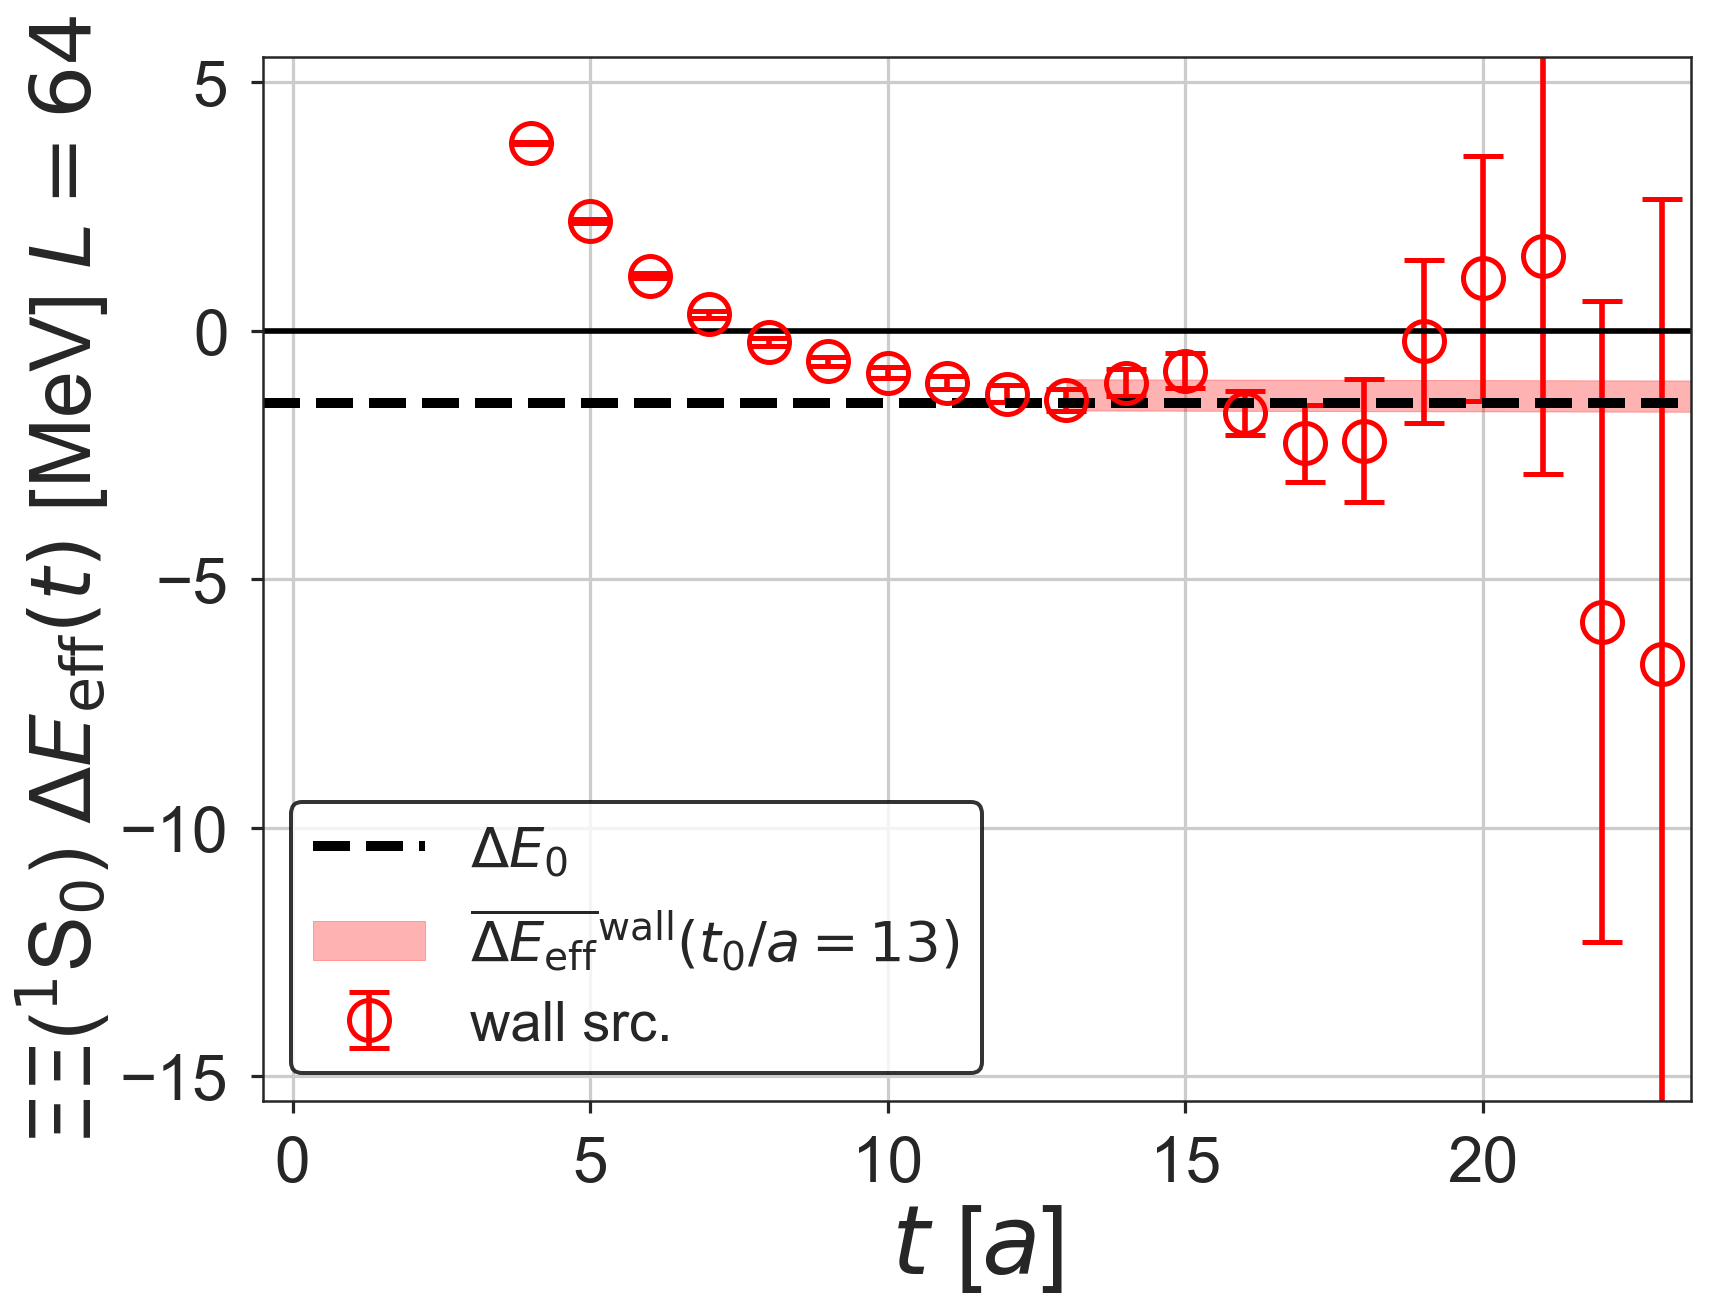

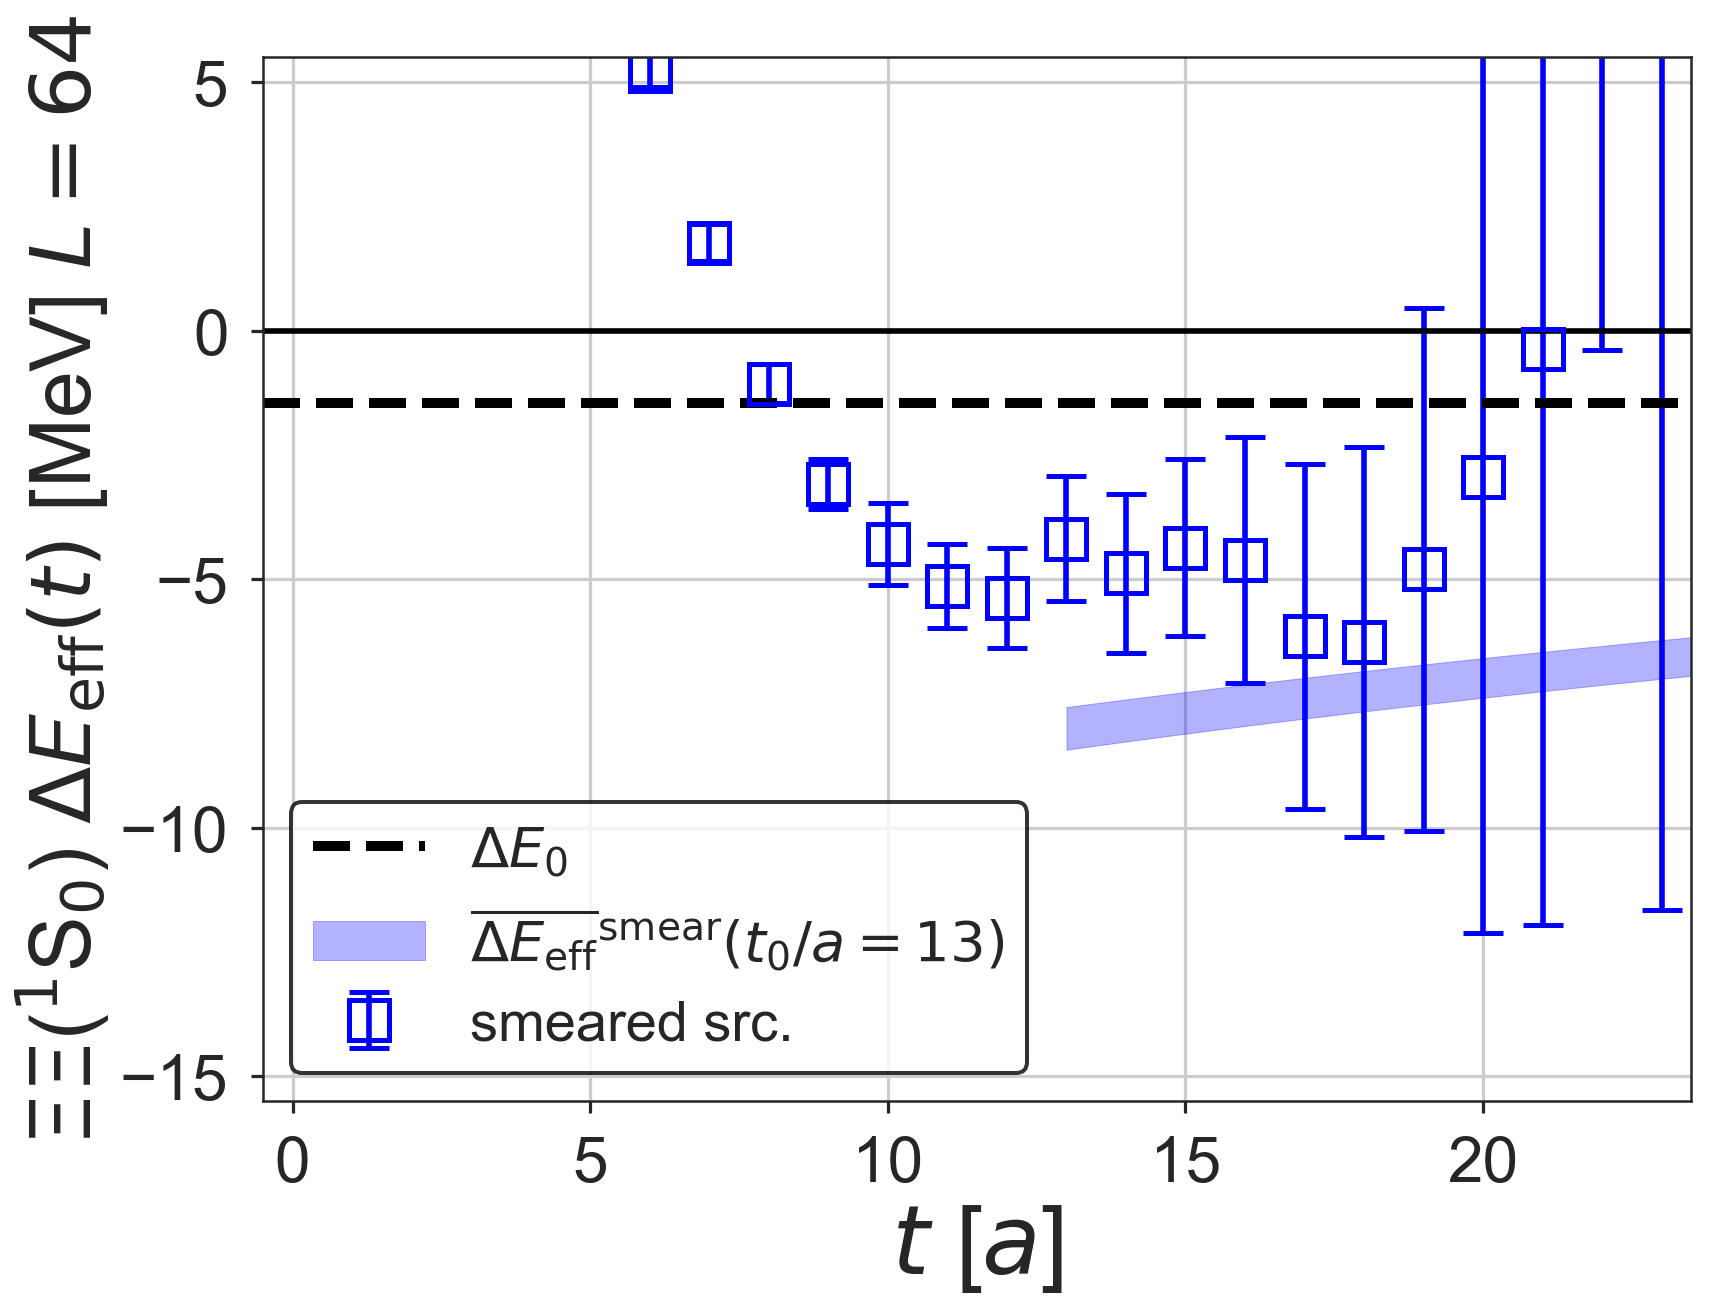

In [16]:
def plot_dEeff_with_ReEeff_src(L, src0, it0 = 13):
    fig, ax = plt.subplots()
    if src0 == 'wall':
        ax.errorbar(dEeffs[(L,'wall')][:,0], dEeffs[(L,'wall')][:,3]*ainv, dEeffs[(L,'wall')][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    elif src0 == 'exp':
        ax.errorbar(dEeffs[(L,'exp')][:,0], dEeffs[(L,'exp')][:,3]*ainv, dEeffs[(L,'exp')][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 24)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        if not src == src0: continue
        ReEeff = eval_ReEeff(L, src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}(t_0/a = {})$'.format({'wall':'wall','exp':'smear'}[src],
                                                                                                       it0))  
    eigen_av = eigenvals[(L,it0)][:,0].mean()
    ax.axhline(eigen_av*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))
    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='lower left', frameon=True, fontsize=28)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'$\Xi\Xi$($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/dEeffs/REdEeff_{src0}_{L}.pdf', bbox_inches='tight')

for L in [40, 48, 64]:
    for src in ['wall', 'exp']:
        plot_dEeff_with_ReEeff_src(L, src)

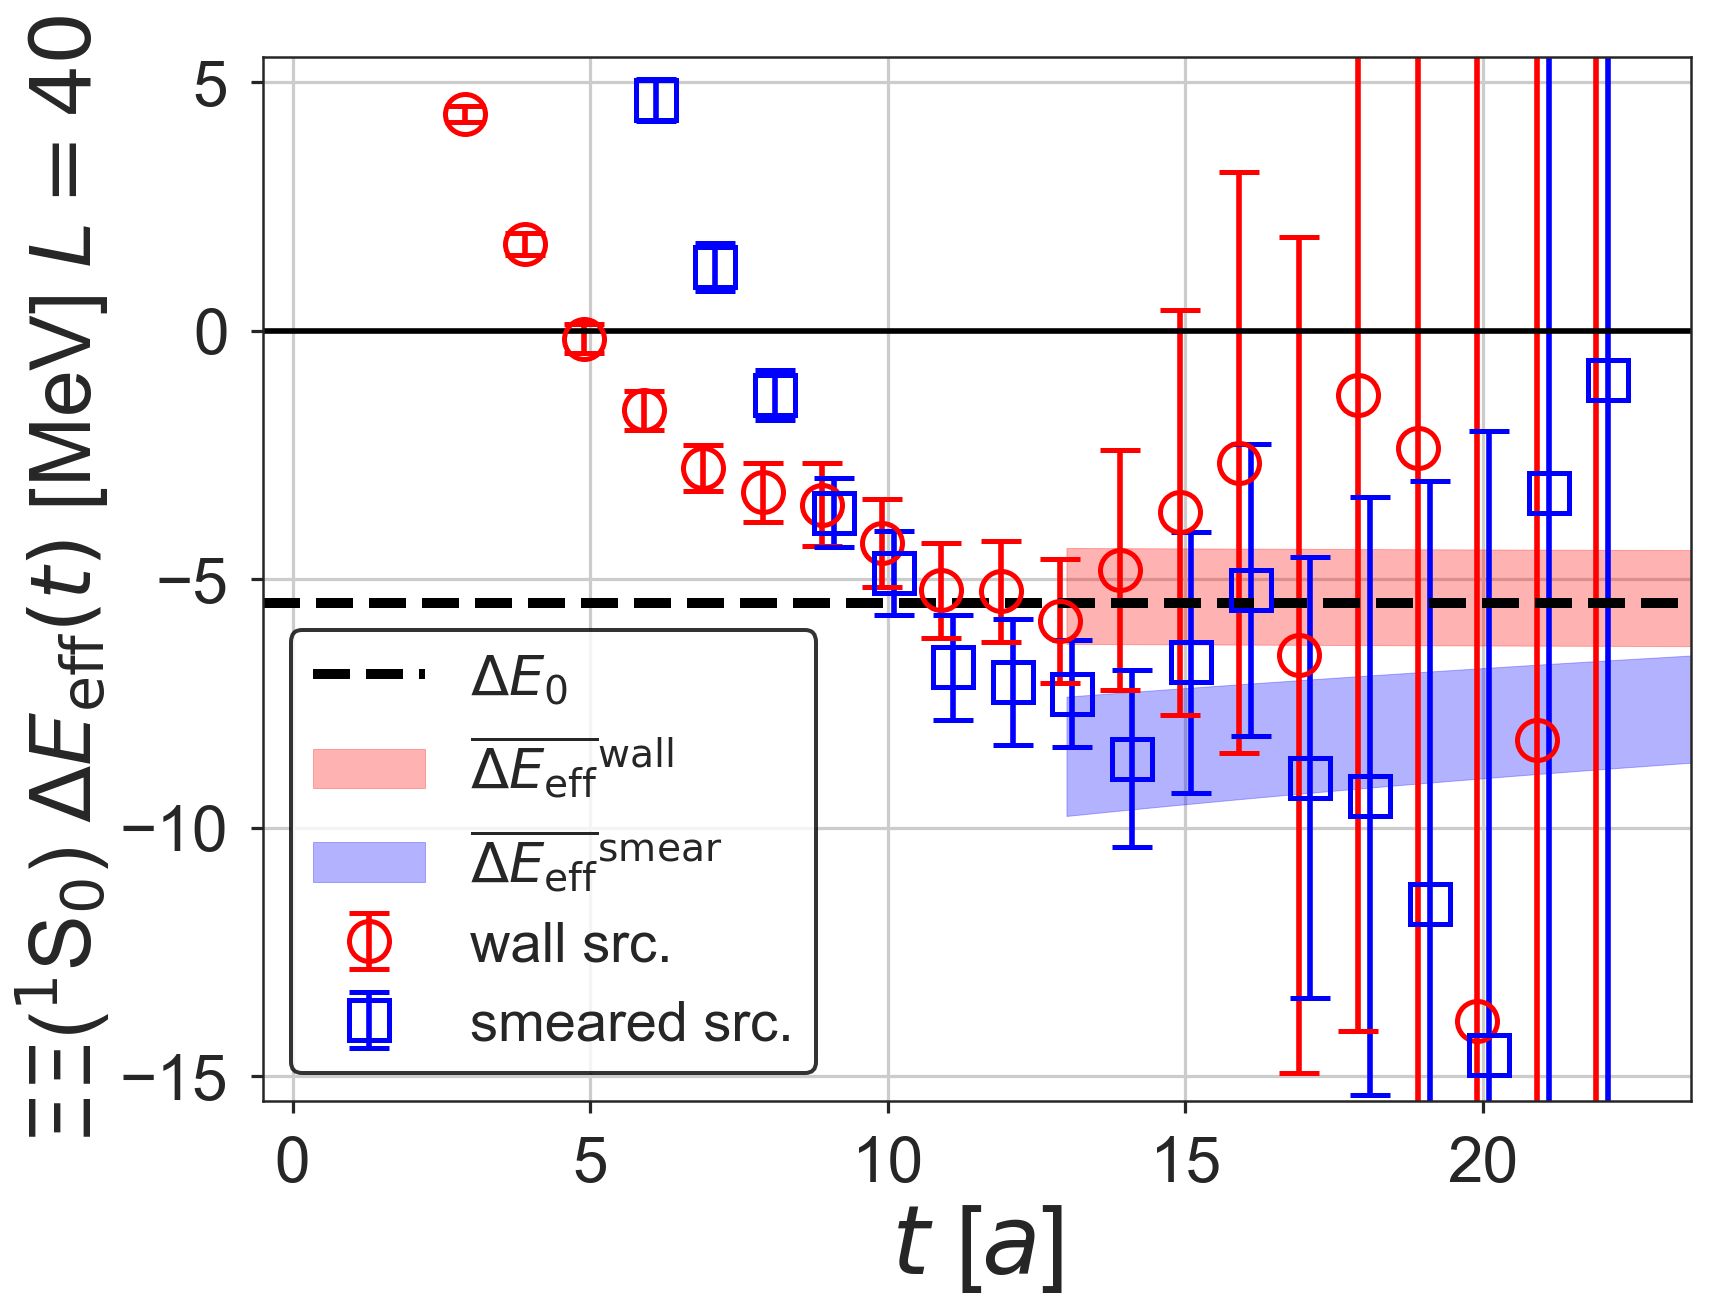

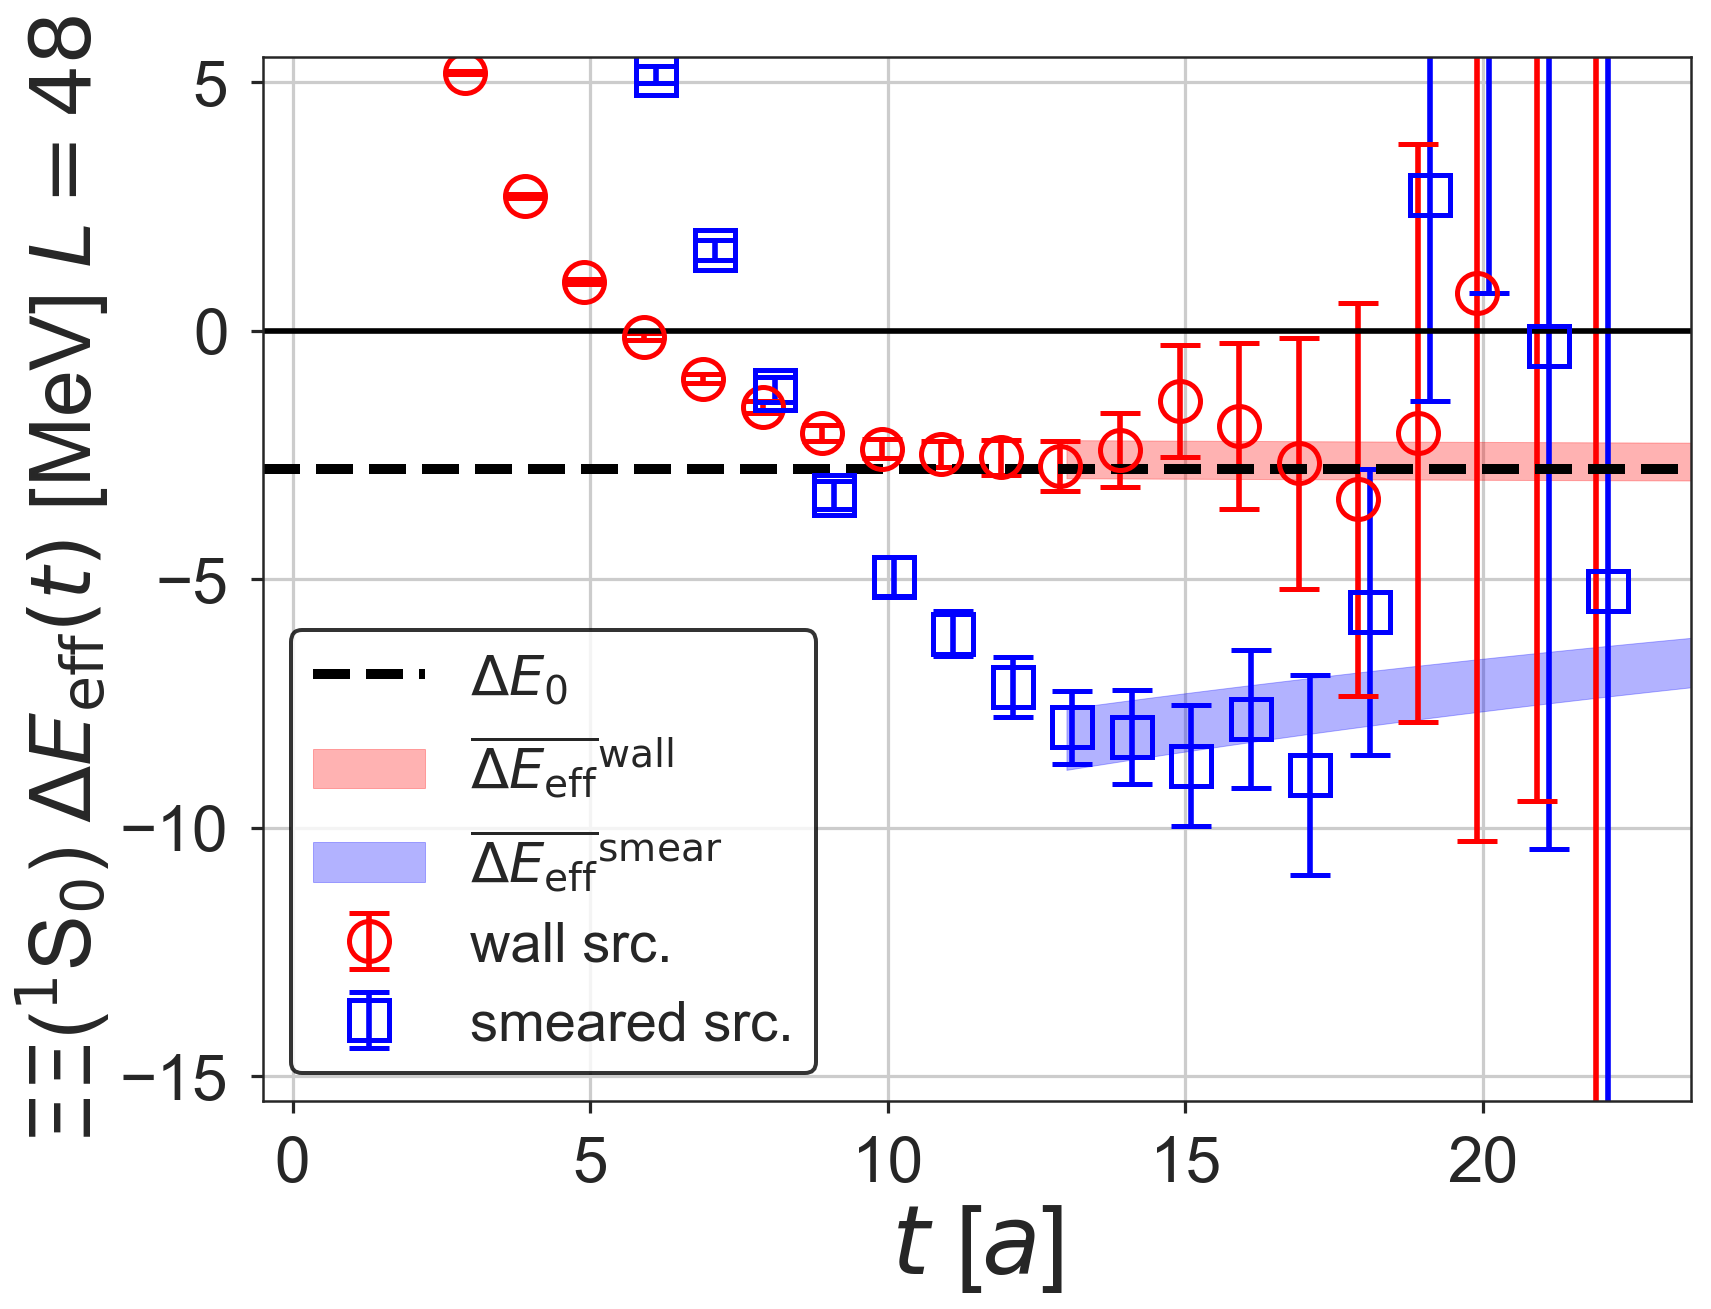

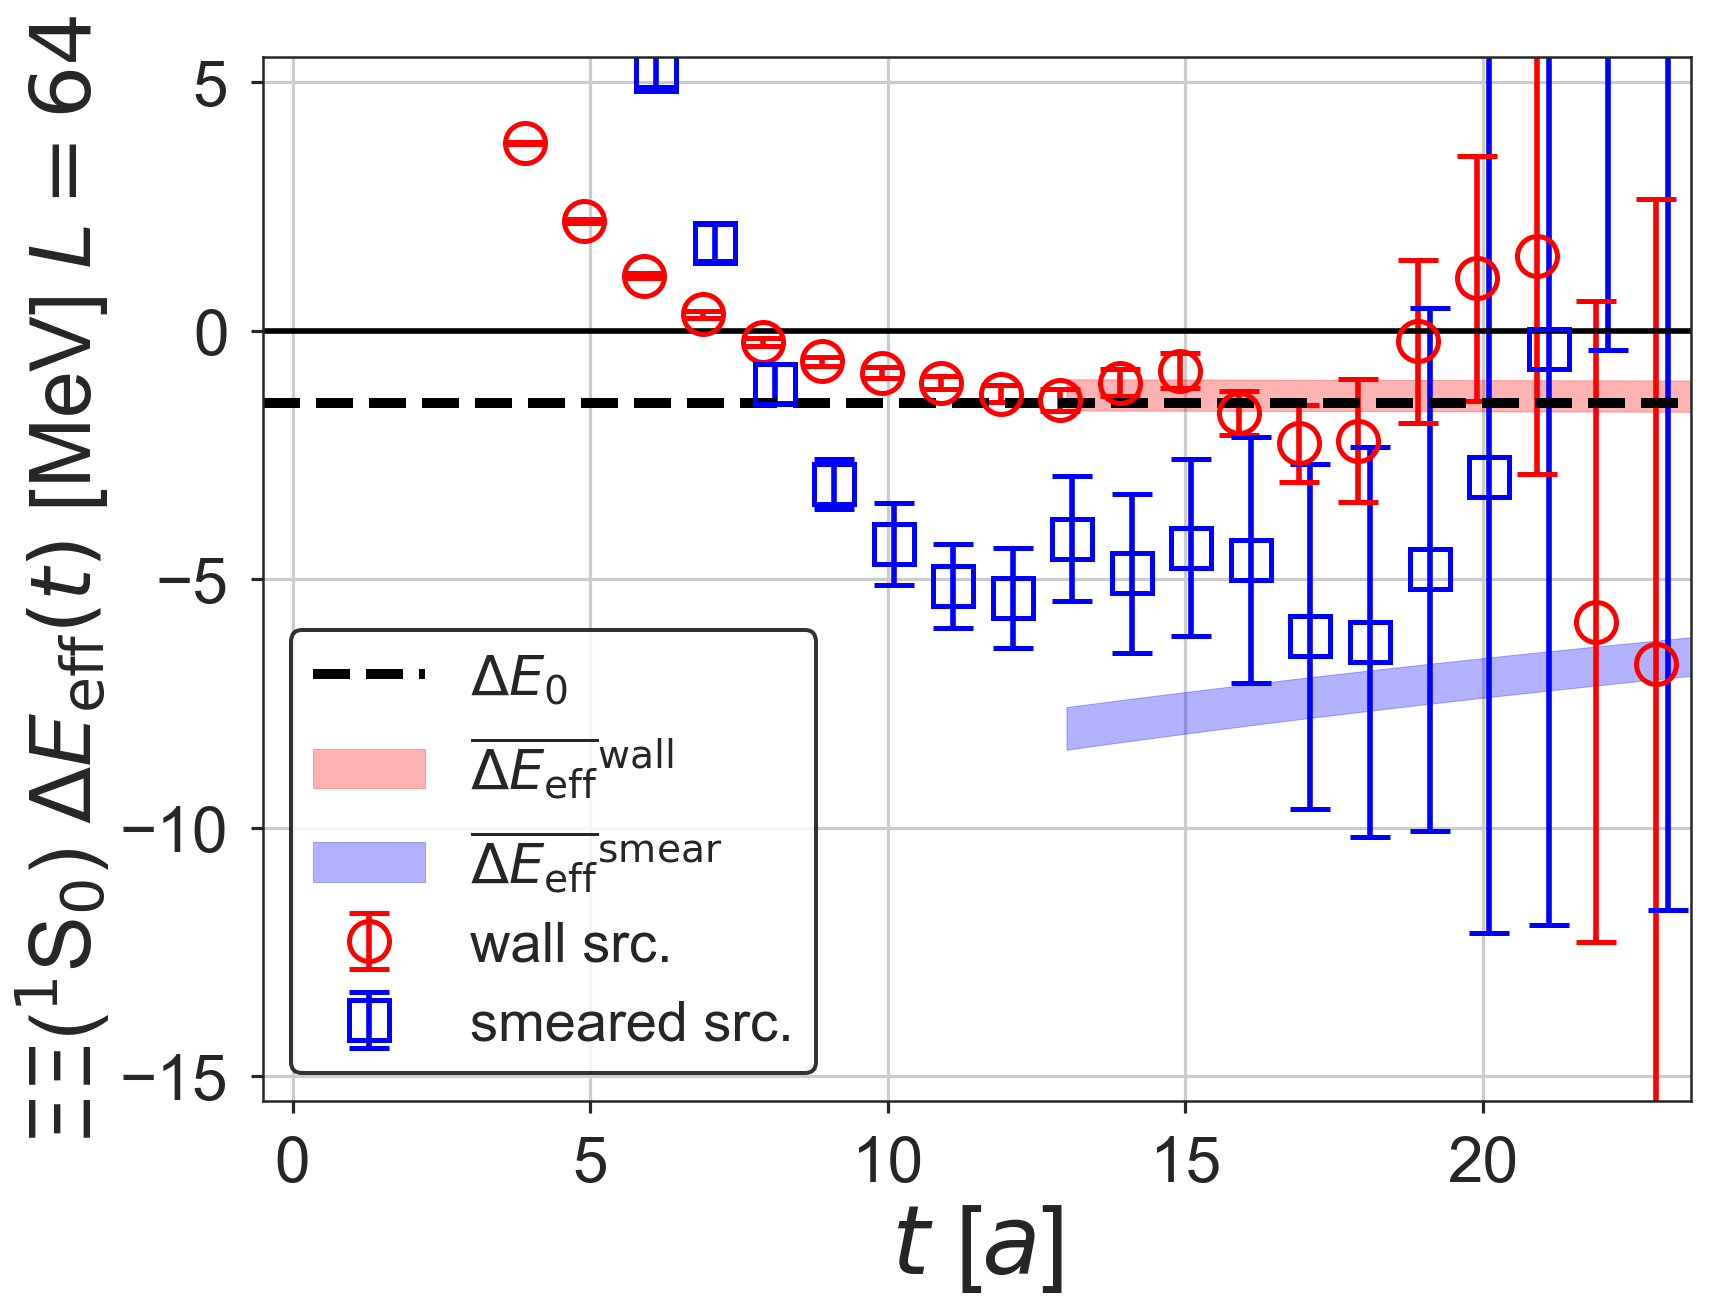

In [17]:
def plot_dEeff_with_ReEeff(L, it0 = 13):
    fig, ax = plt.subplots()
    ax.errorbar(dEeffs[(L,'wall')][:,0]-0.1, dEeffs[(L,'wall')][:,3]*ainv, dEeffs[(L,'wall')][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    ax.errorbar(dEeffs[(L,'exp')][:,0]+0.1, dEeffs[(L,'exp')][:,3]*ainv, dEeffs[(L,'exp')][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 24)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        ReEeff = eval_ReEeff(L, src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}$'.format({'wall':'wall','exp':'smear'}[src]
                                                                                                     ))
    eigen_av = eigenvals[(L,it0)][:,0].mean()
    ax.axhline(eigen_av*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))
    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='lower left', frameon=True, fontsize=28)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'$\Xi\Xi$($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/dEeffs/REdEeff_wall_vs_smear_{L}.pdf', bbox_inches='tight')

for L in [40, 48, 64]:
    plot_dEeff_with_ReEeff(L)

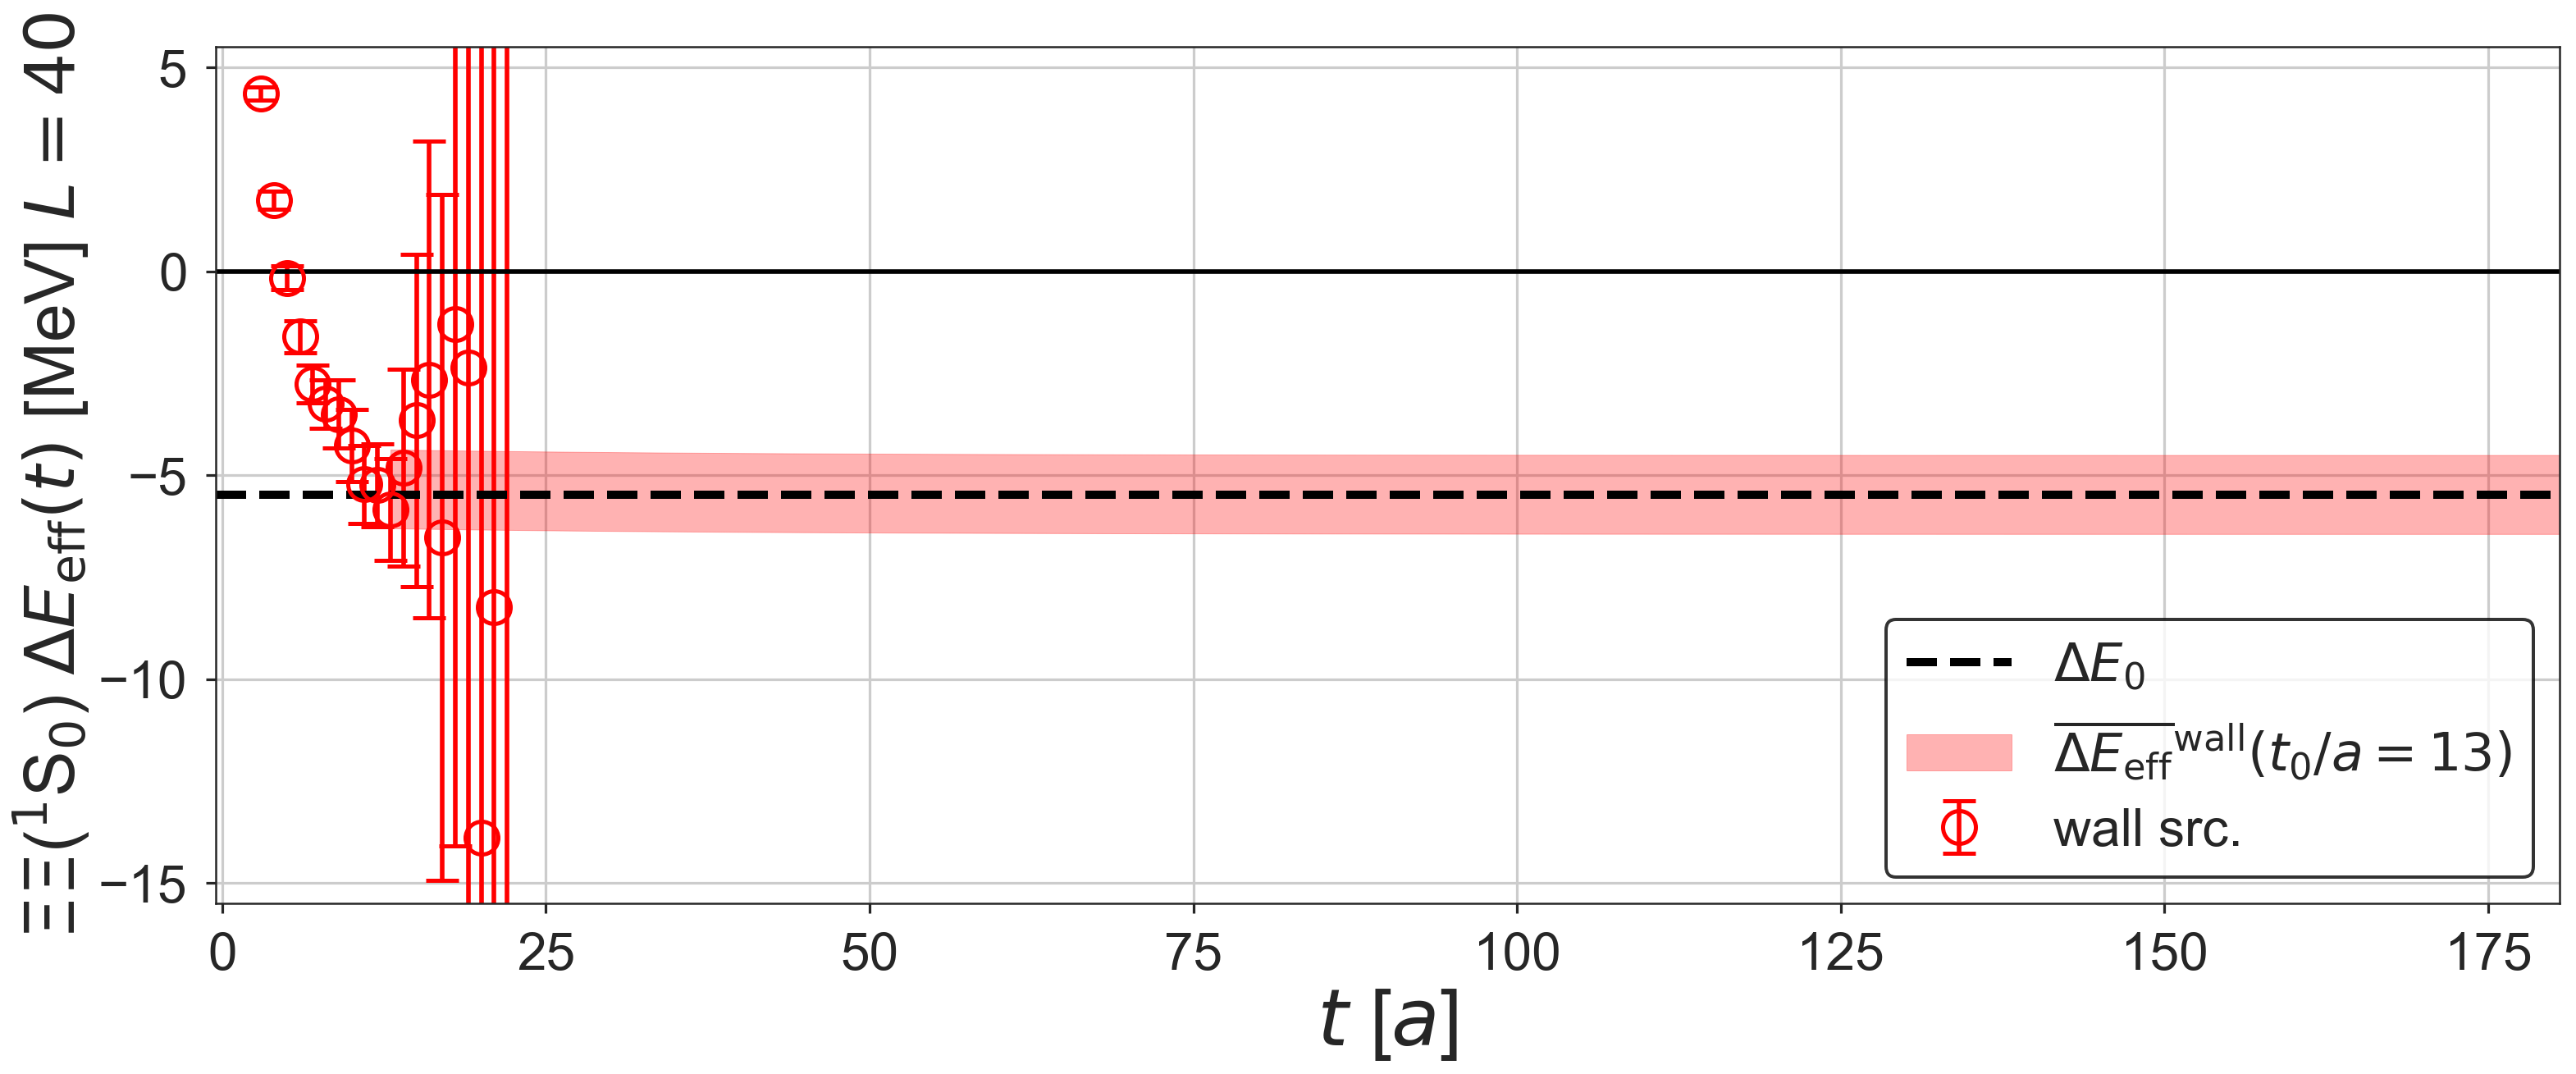

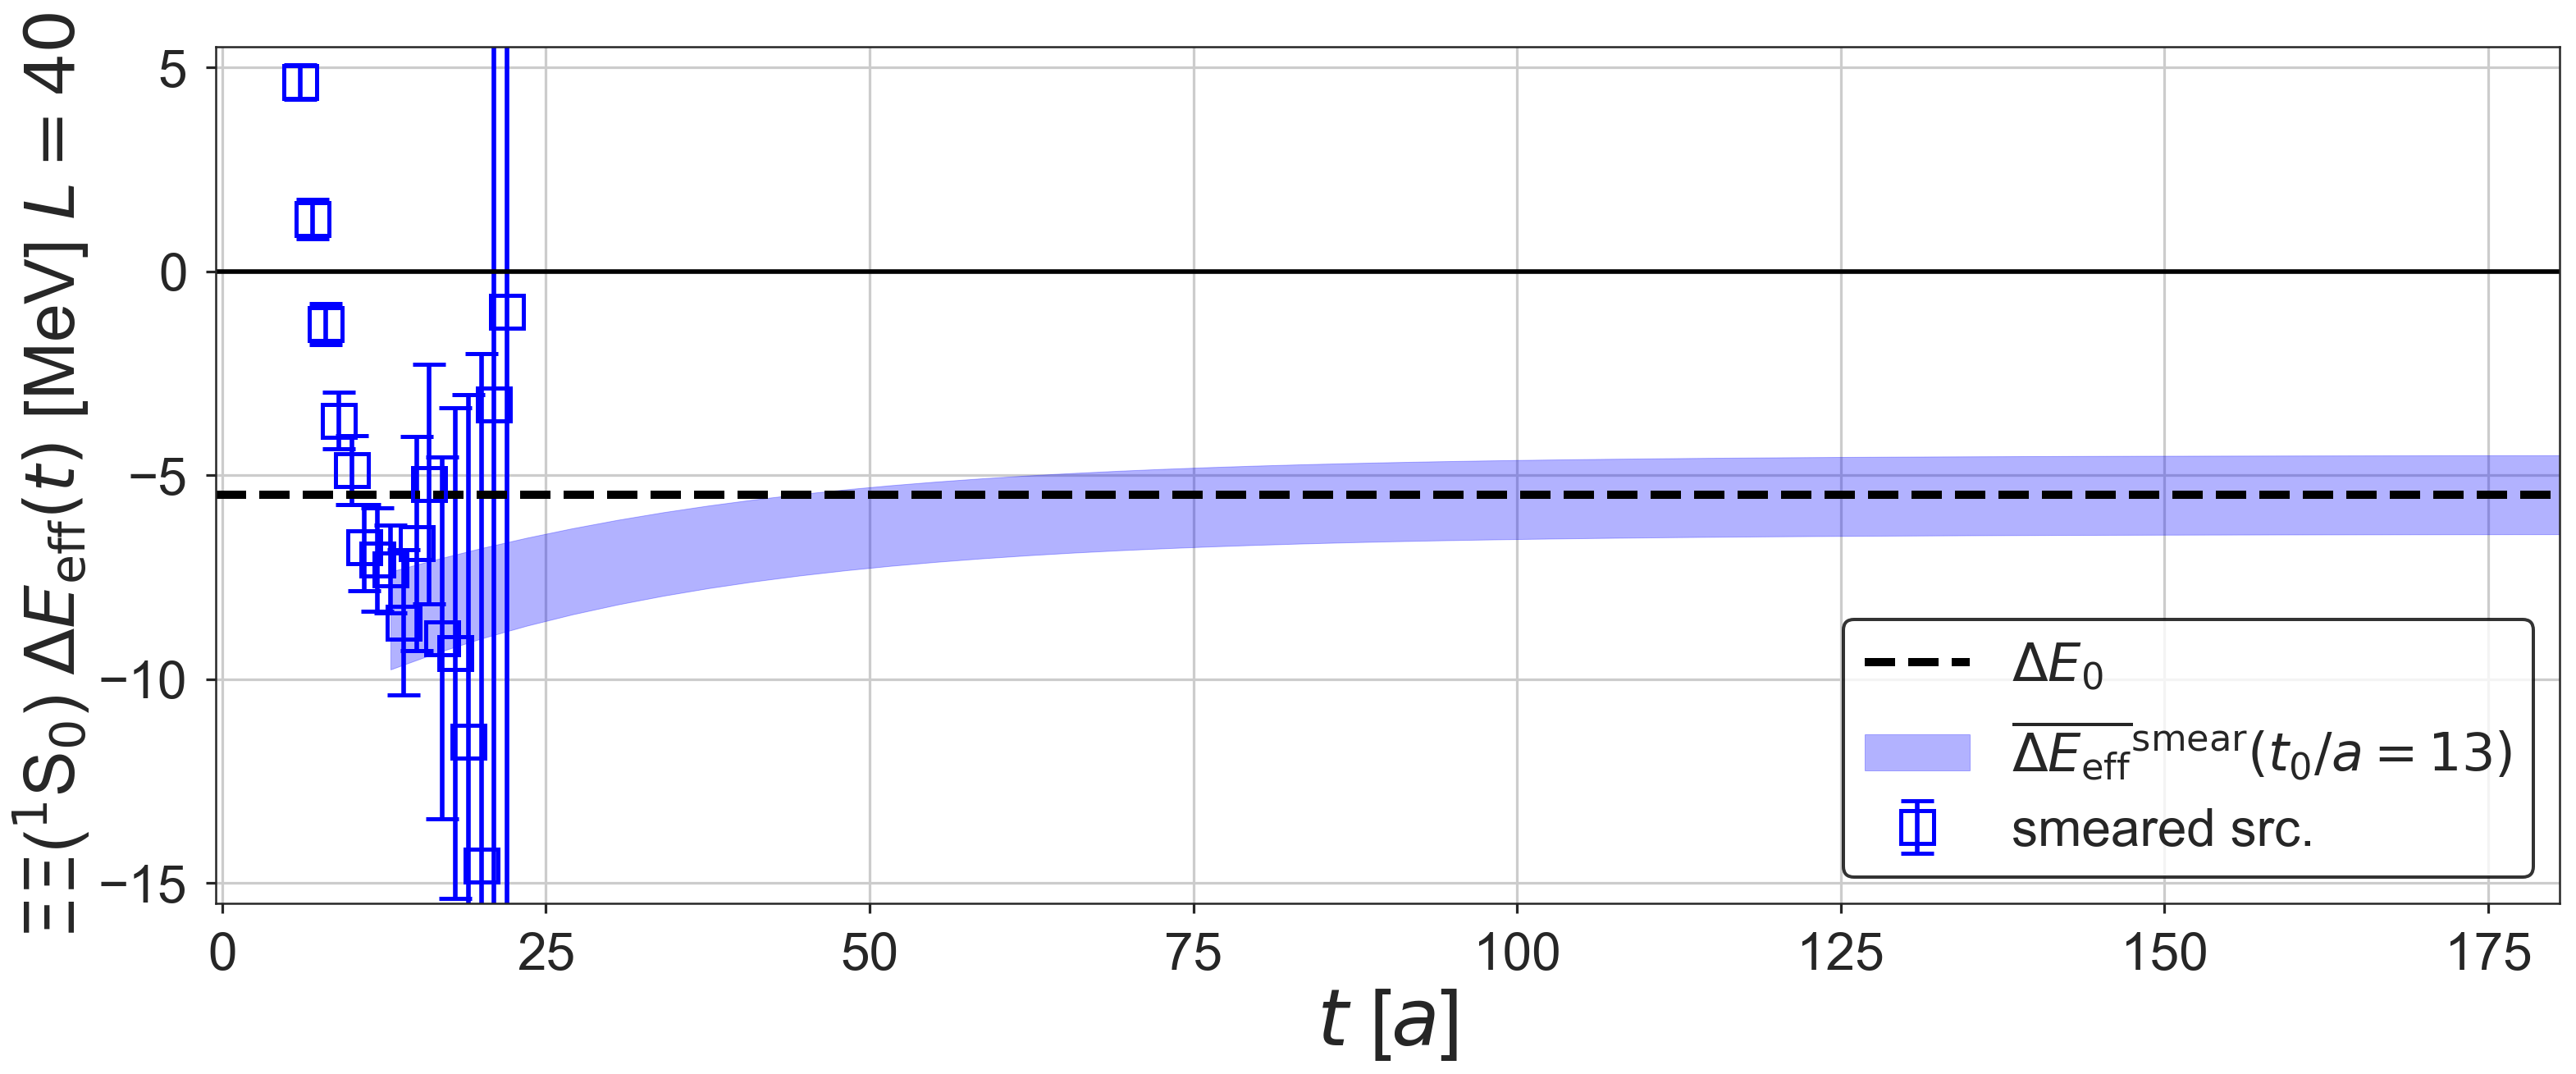

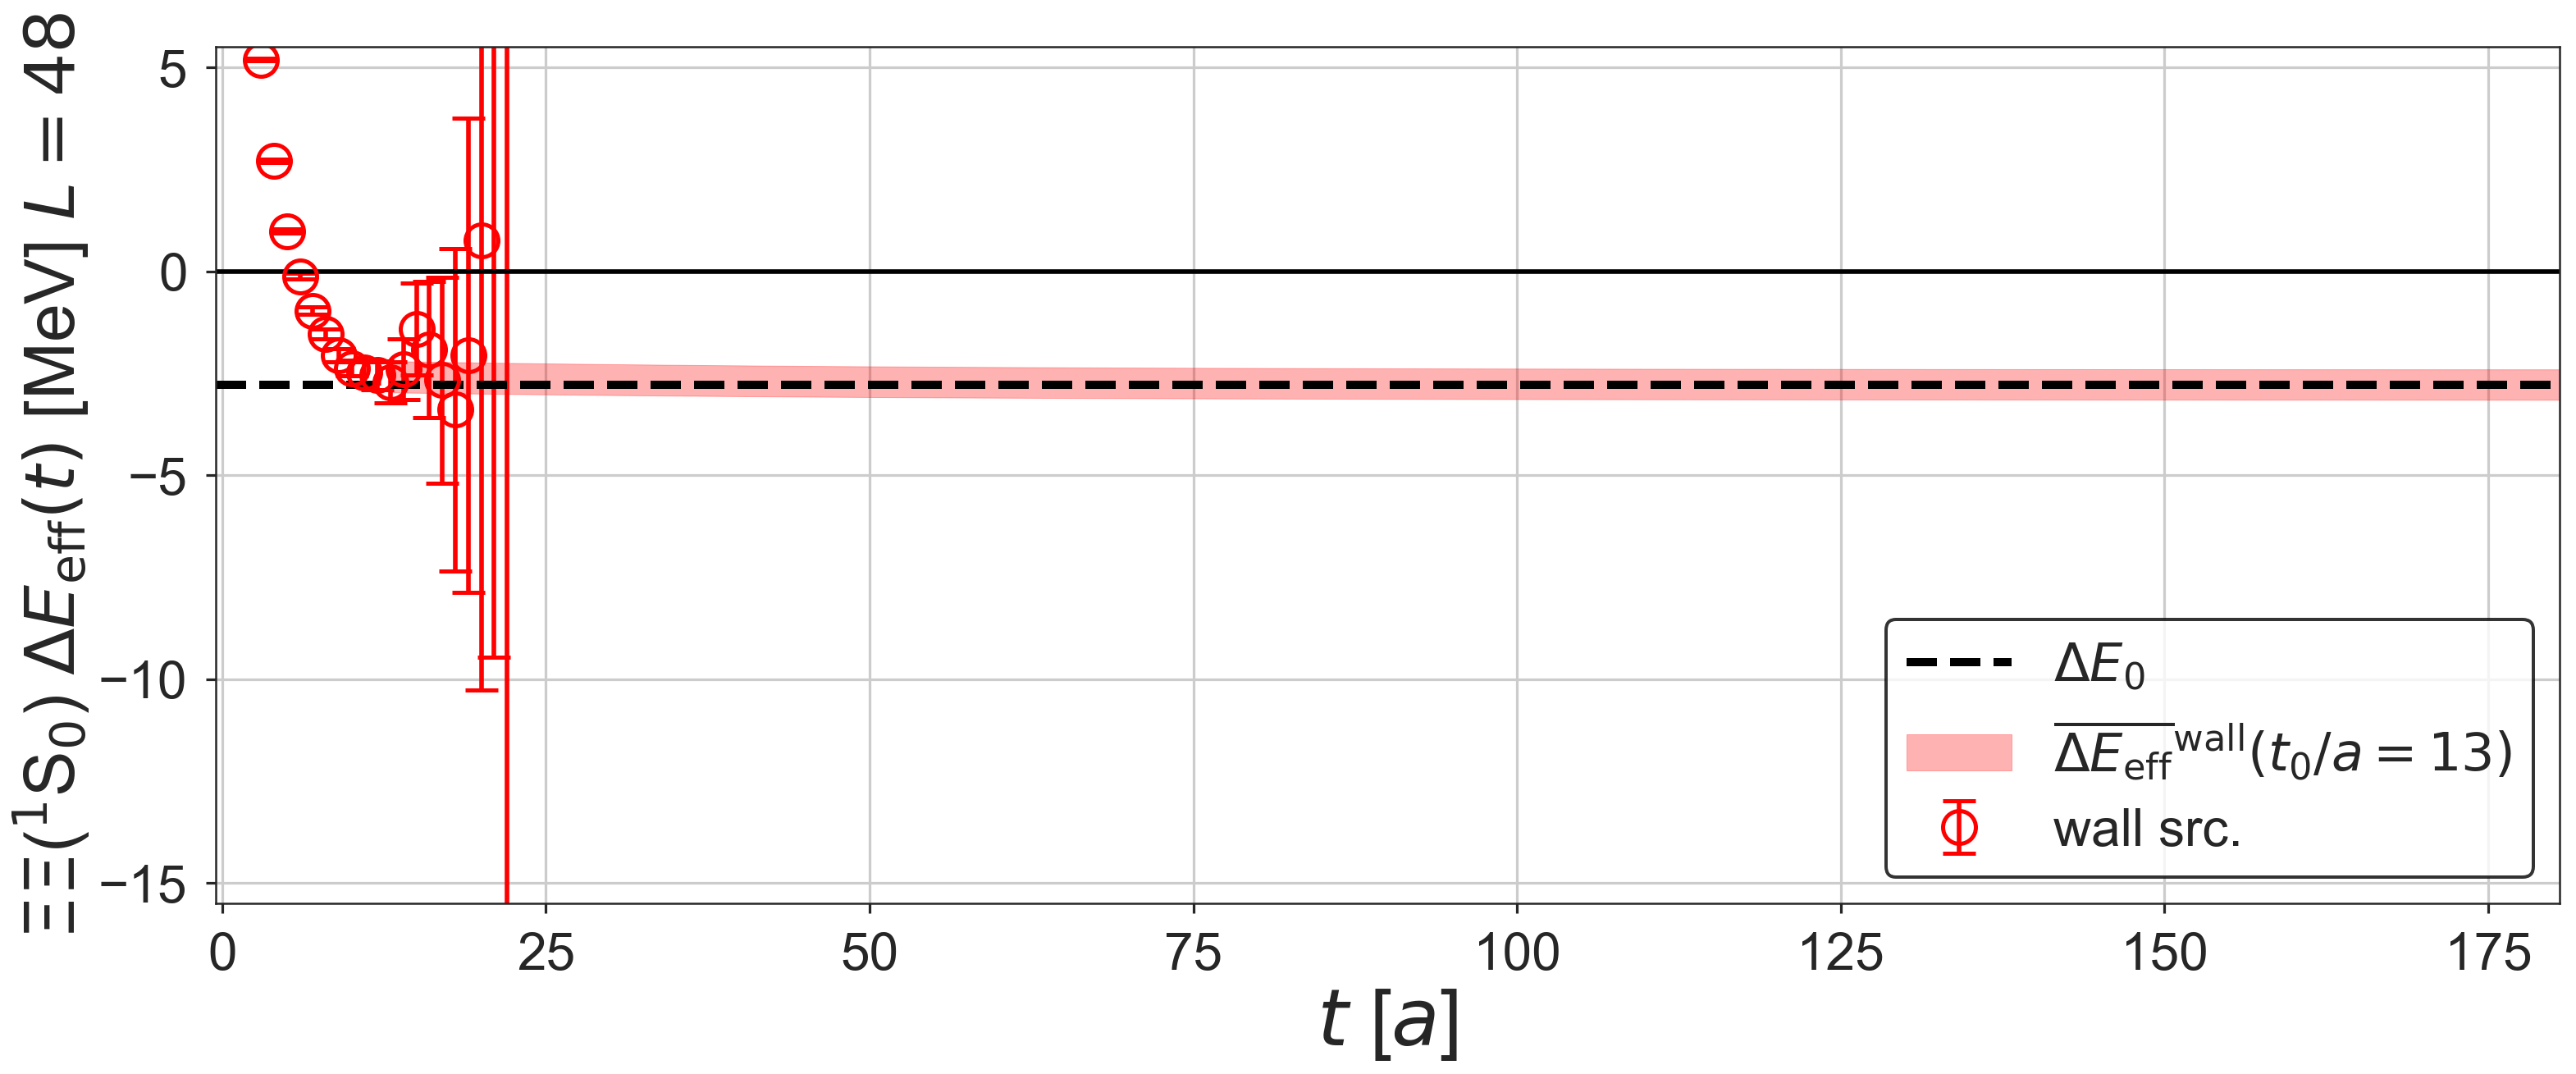

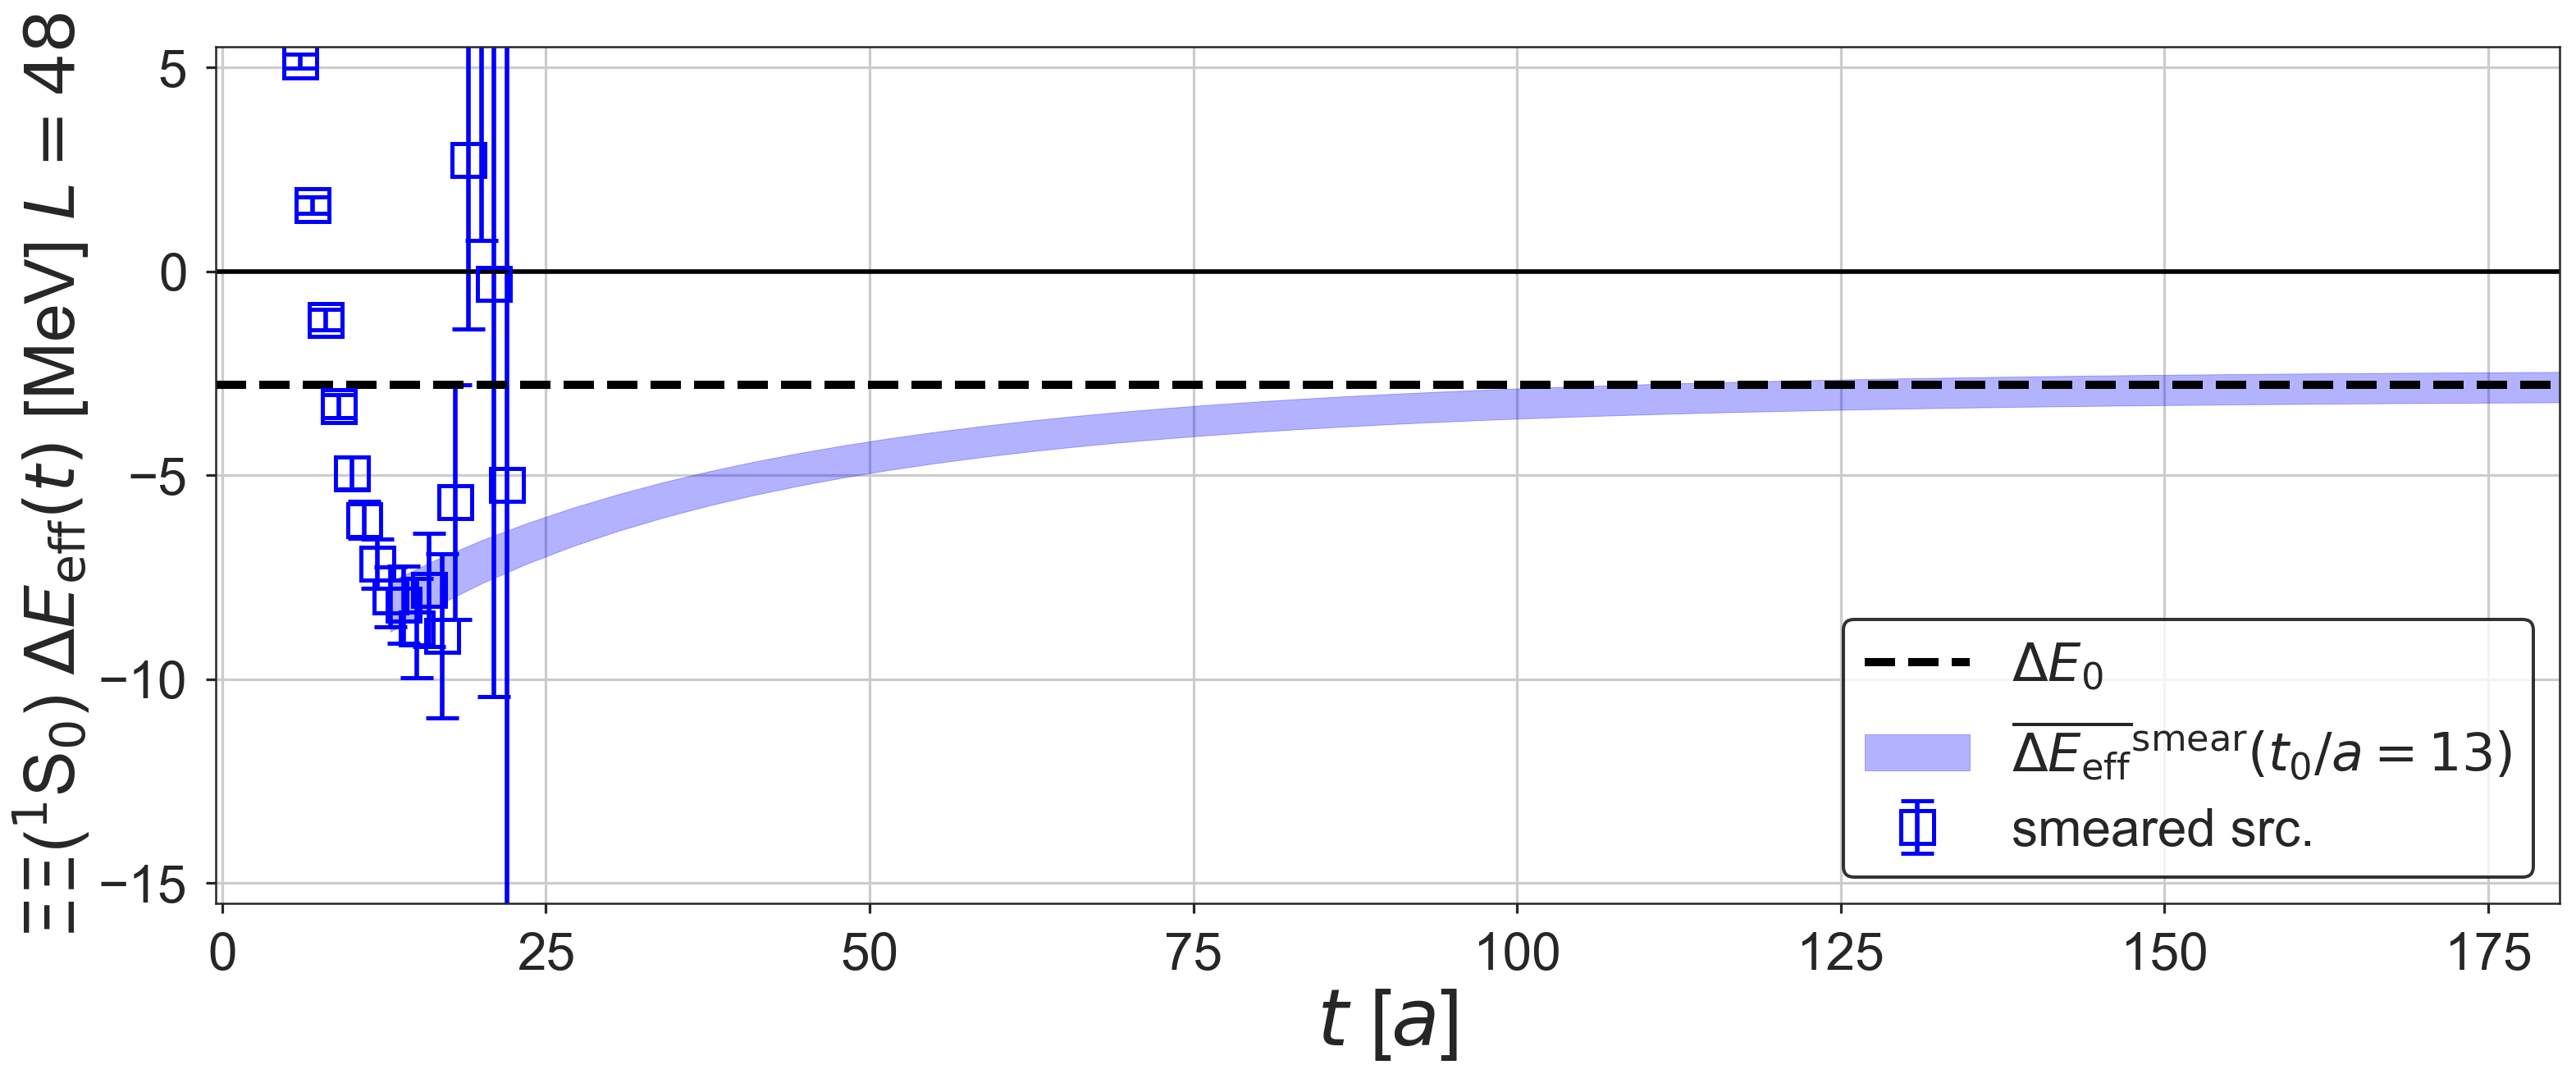

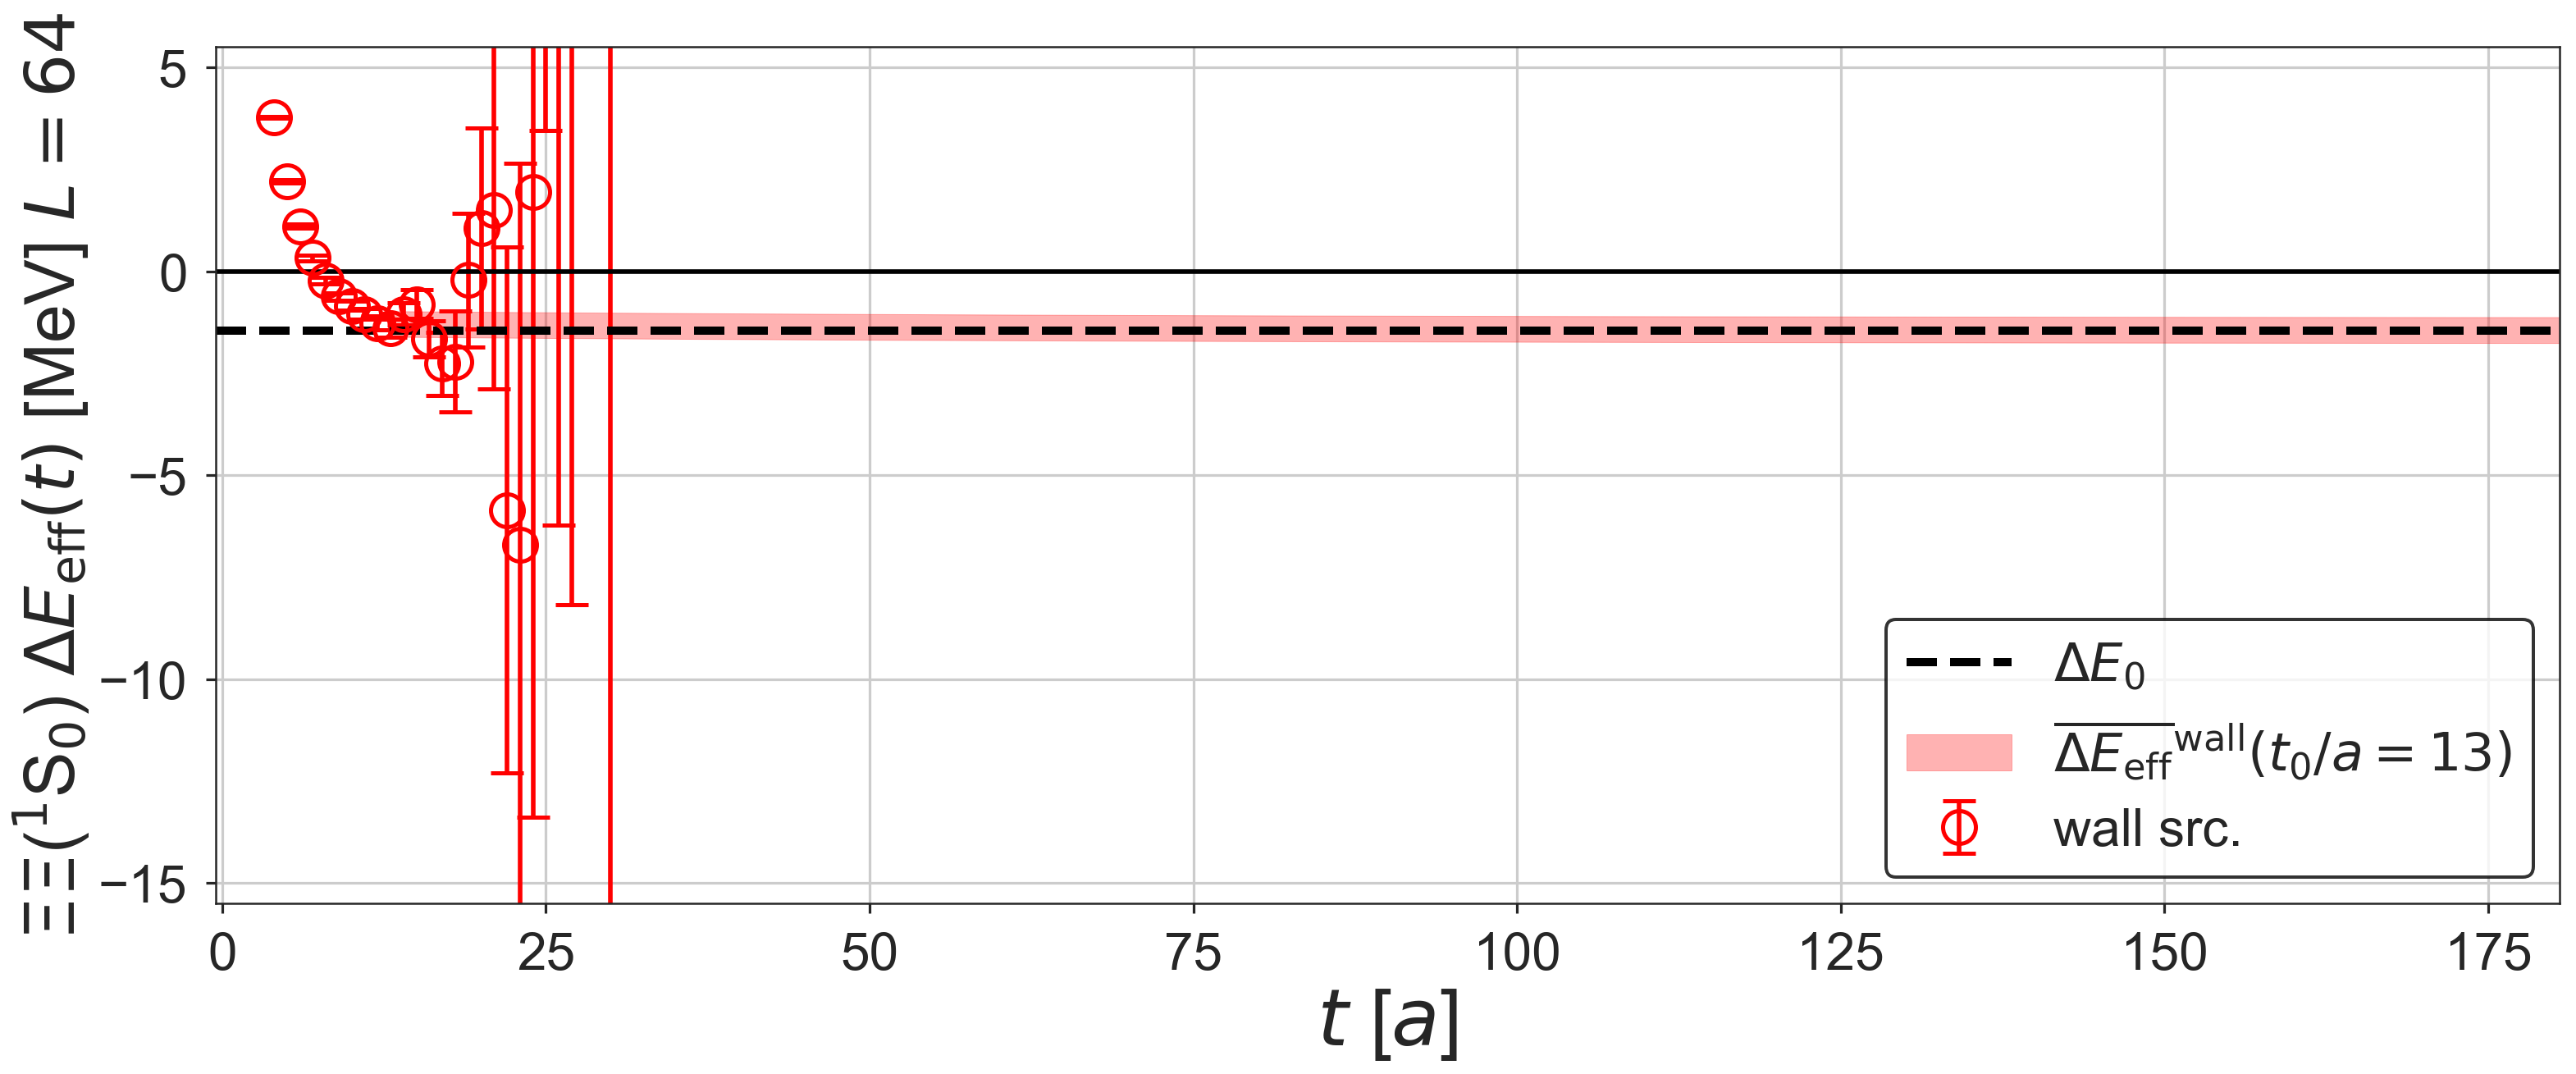

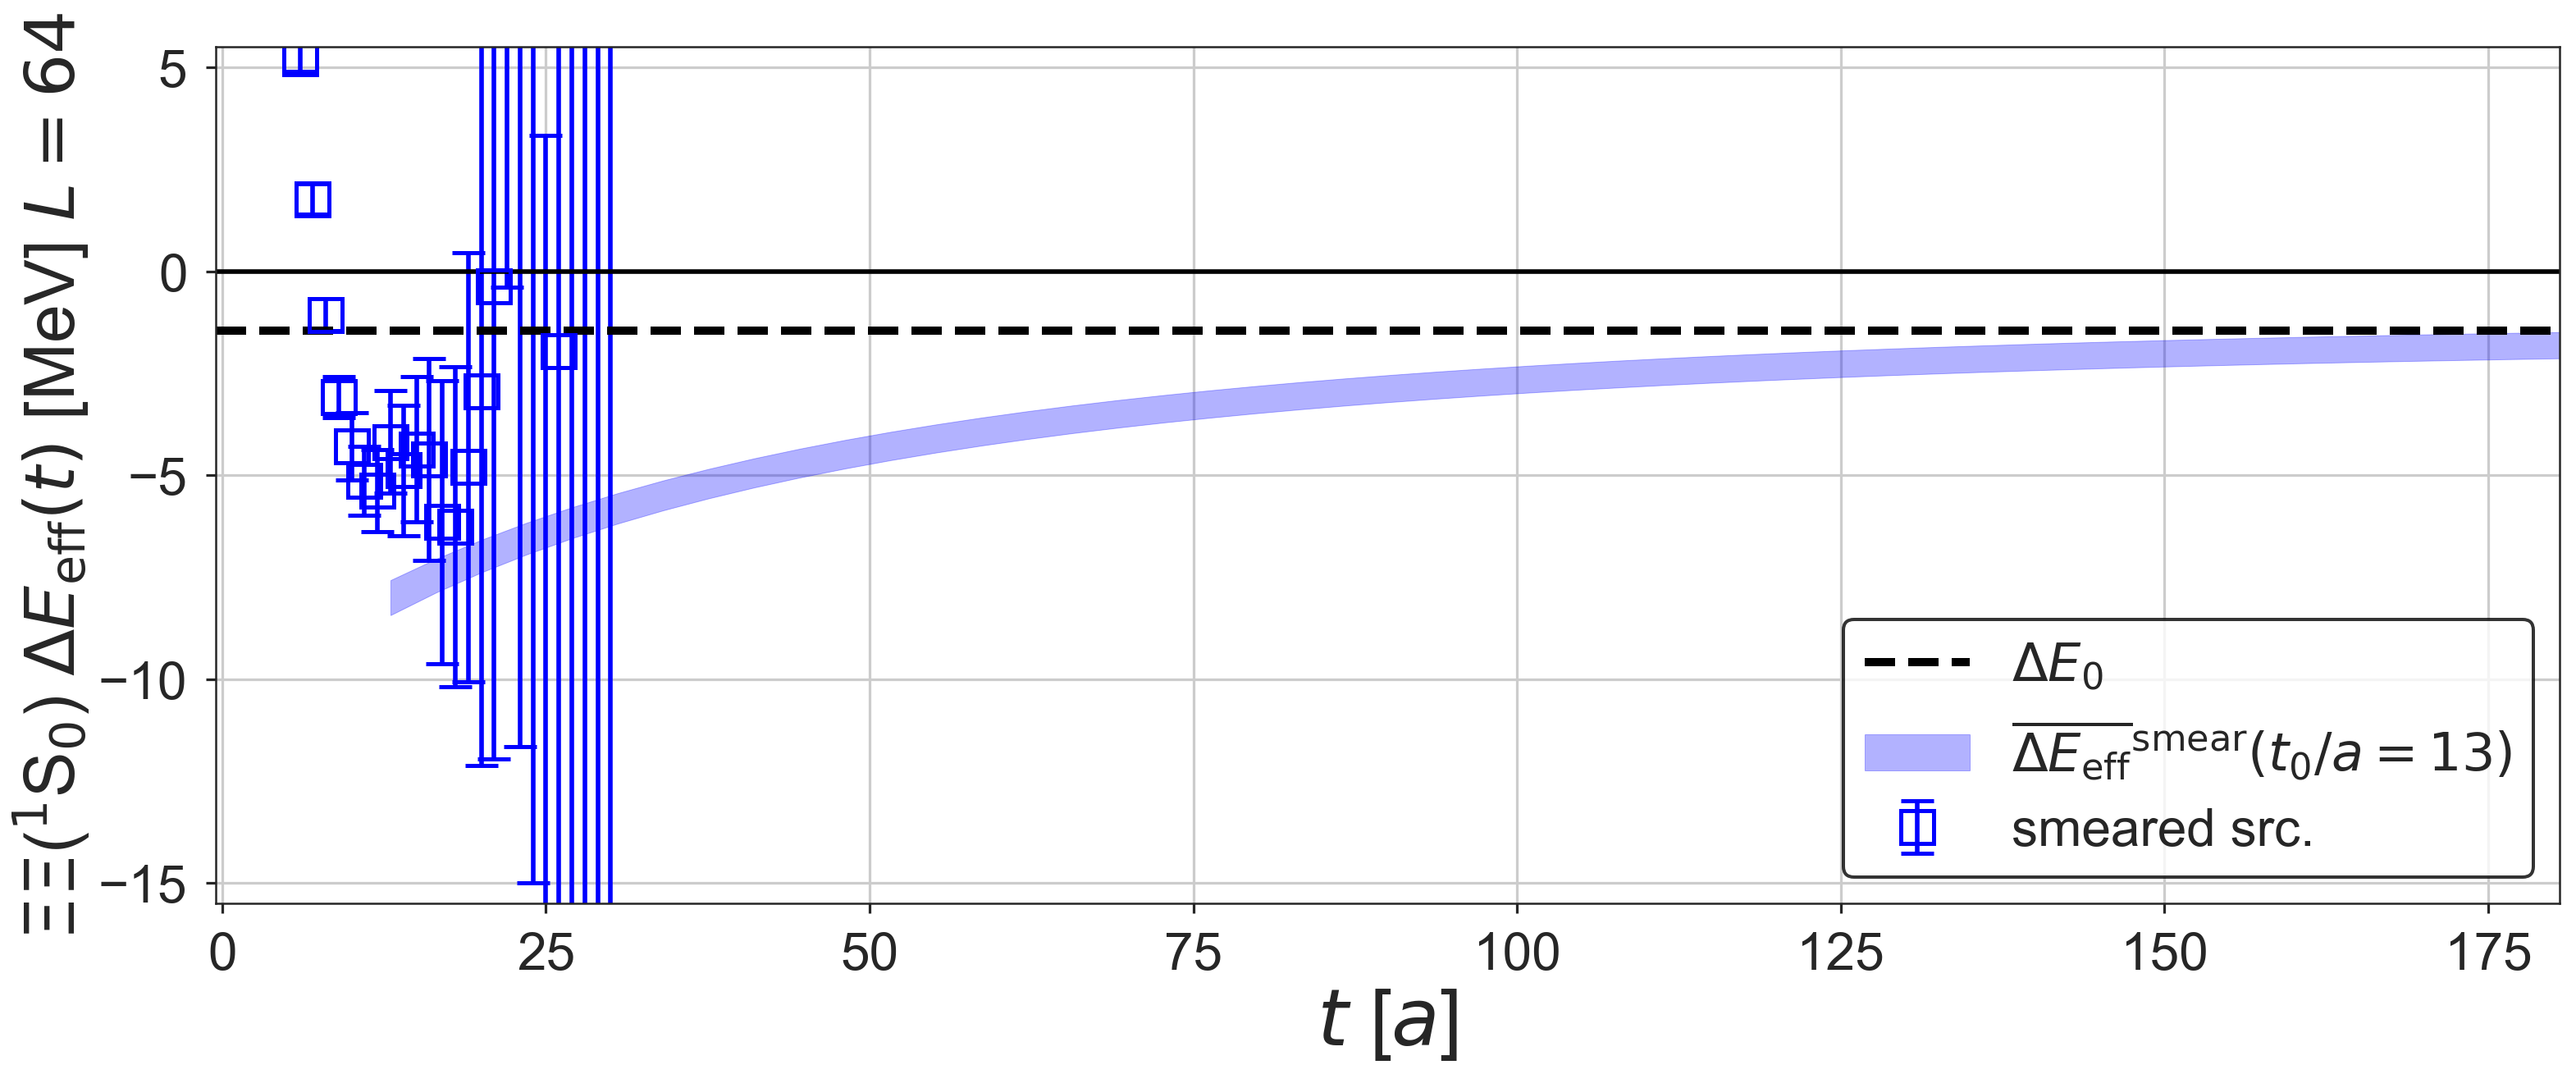

In [18]:
def plot_dEeff_with_ReEeff_large_t_src(L, src0, it0 = 13):
#     (12.8, 9.6)
    fig, ax = plt.subplots(figsize=(12.8*2,9.6))
#    fig, ax = plt.subplots(figsize=(12.8*2/(6.0/4.7),9.6/(6.0/4.7)))

    if src0 == 'wall':
        ax.errorbar(dEeffs[(L,'wall')][:,0], dEeffs[(L,'wall')][:,3]*ainv, dEeffs[(L,'wall')][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    elif src0 == 'exp':
        ax.errorbar(dEeffs[(L,'exp')][:,0], dEeffs[(L,'exp')][:,3]*ainv, dEeffs[(L,'exp')][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 185)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        if not src == src0: continue
        ReEeff = eval_ReEeff(L, src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}(t_0/a={})$'.format({'wall':'wall','exp':'smear'}[src],
                                                                                                     it0))
    eigen_av = eigenvals[(L,it0)][:,0].mean()
    ax.axhline(eigen_av*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))

    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 180.5)
    ax.set_xticks([0, 25, 50, 75, 100, 125, 150, 175])
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(ncol=1, loc='lower right', frameon=True)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'$\Xi\Xi$($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/dEeffs/REdEeff_{src0}_{L}_large_t.pdf', bbox_inches='tight')

for L in [40, 48, 64]:
    for src in ['wall', 'exp']:
        plot_dEeff_with_ReEeff_large_t_src(L, src)

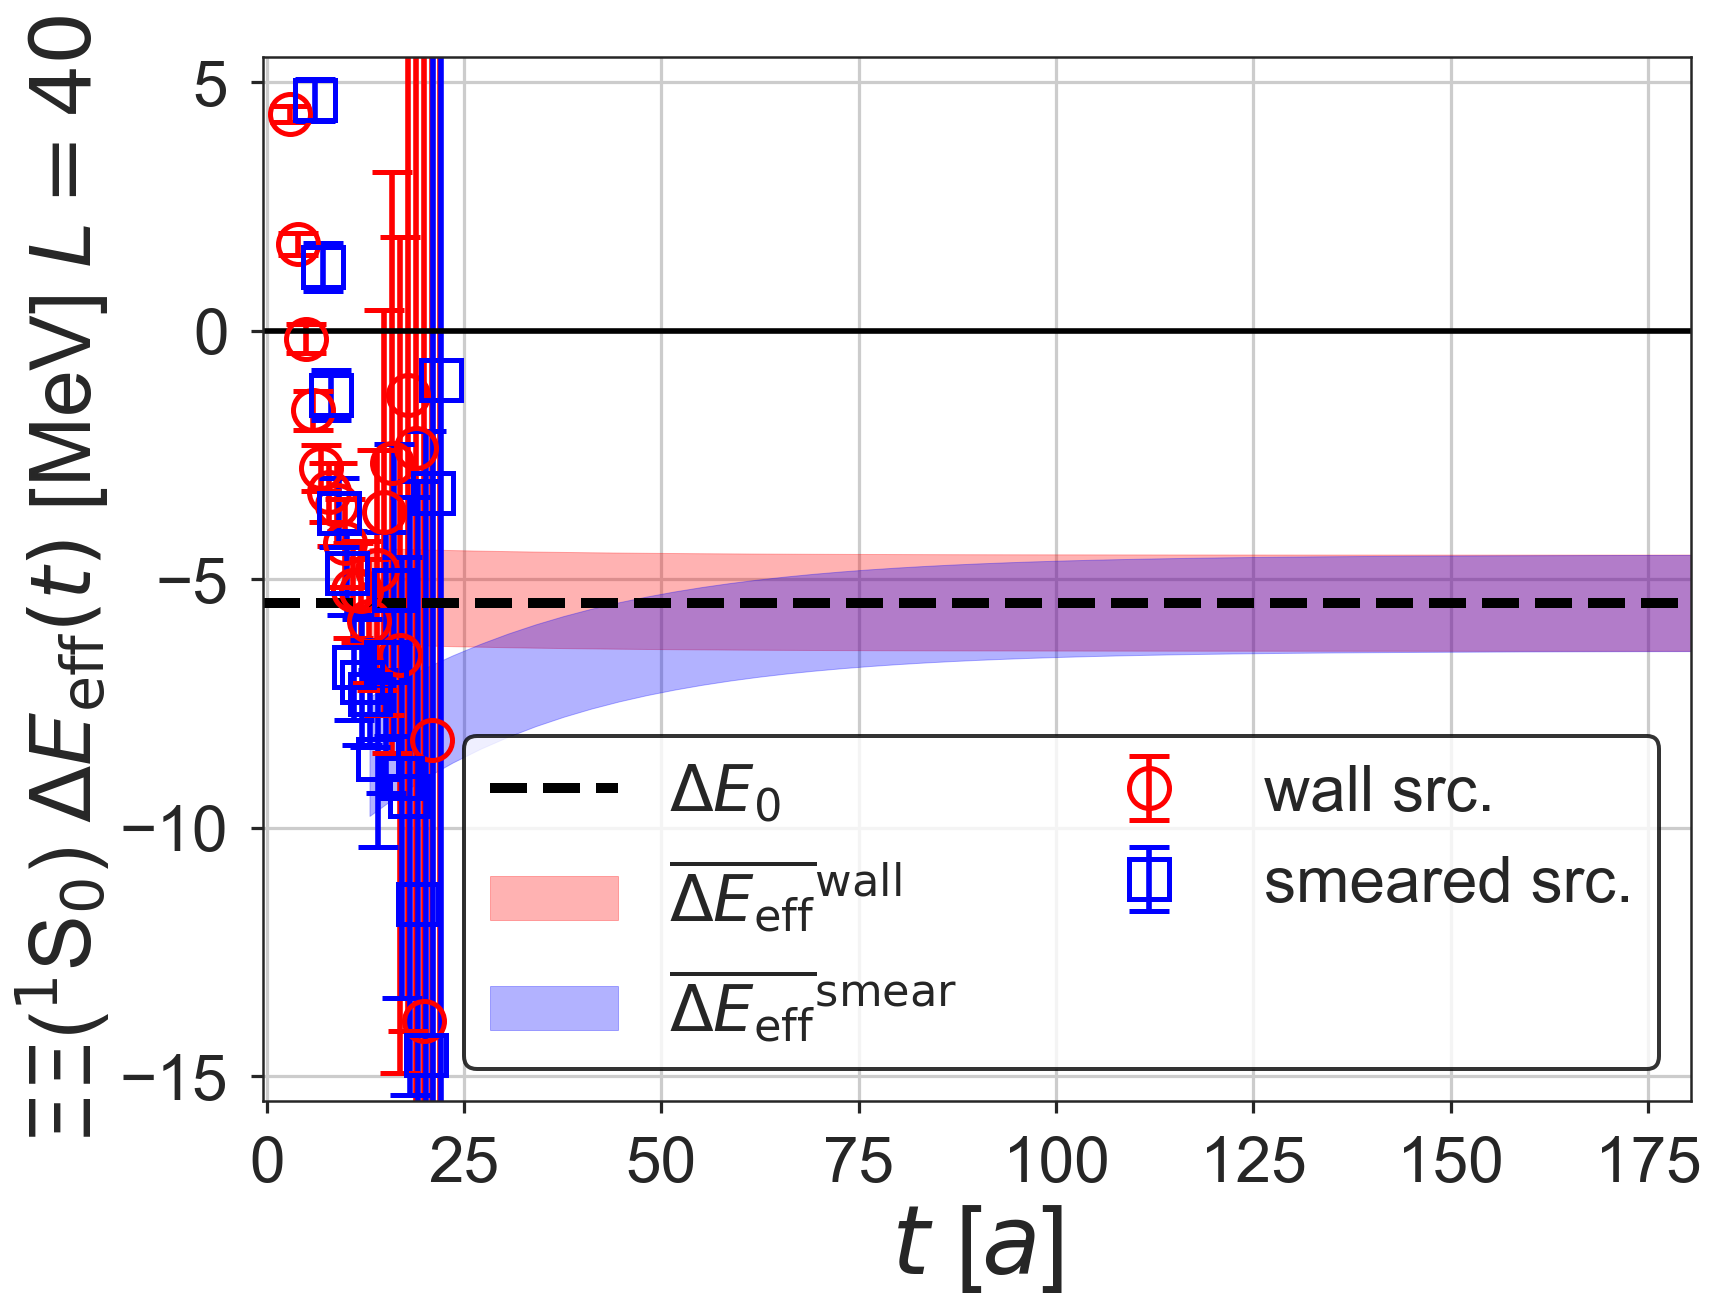

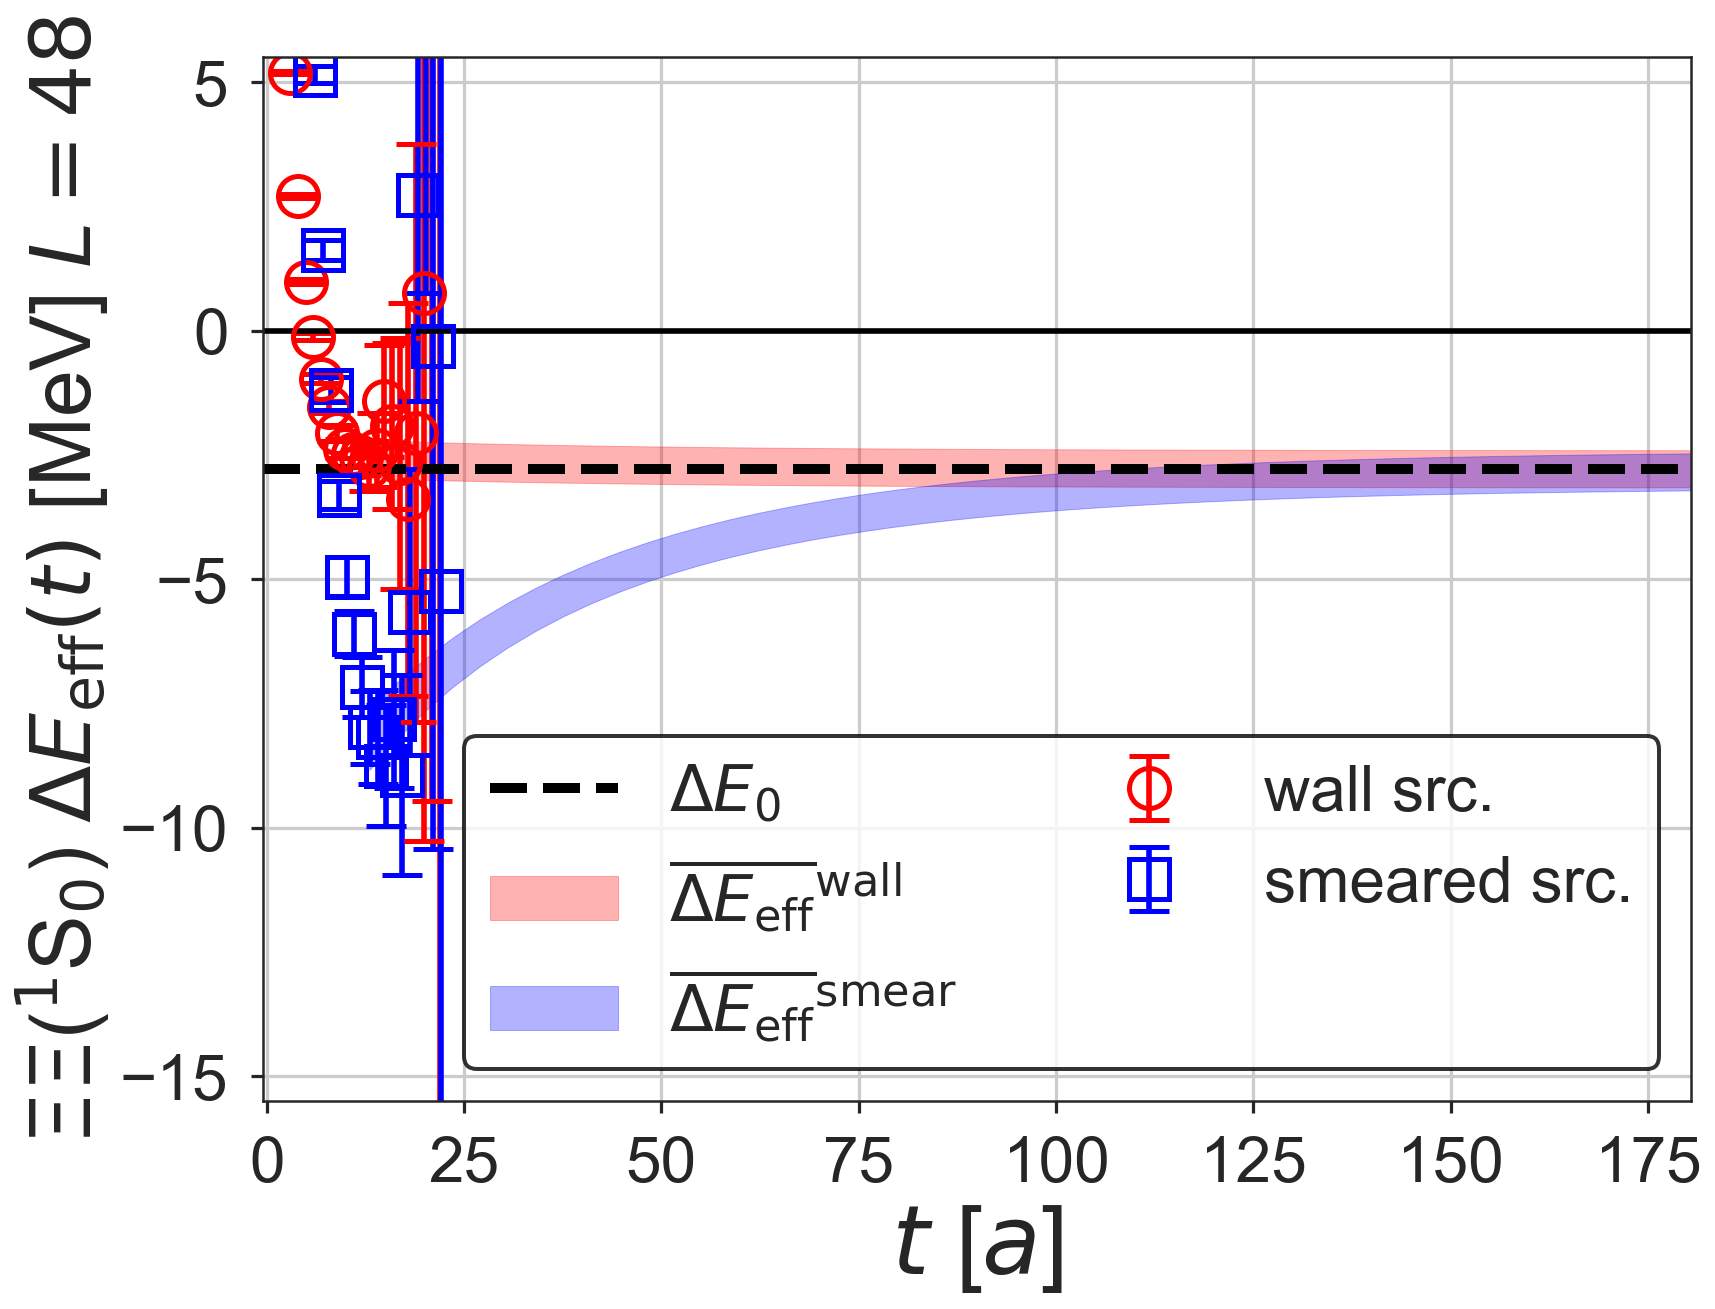

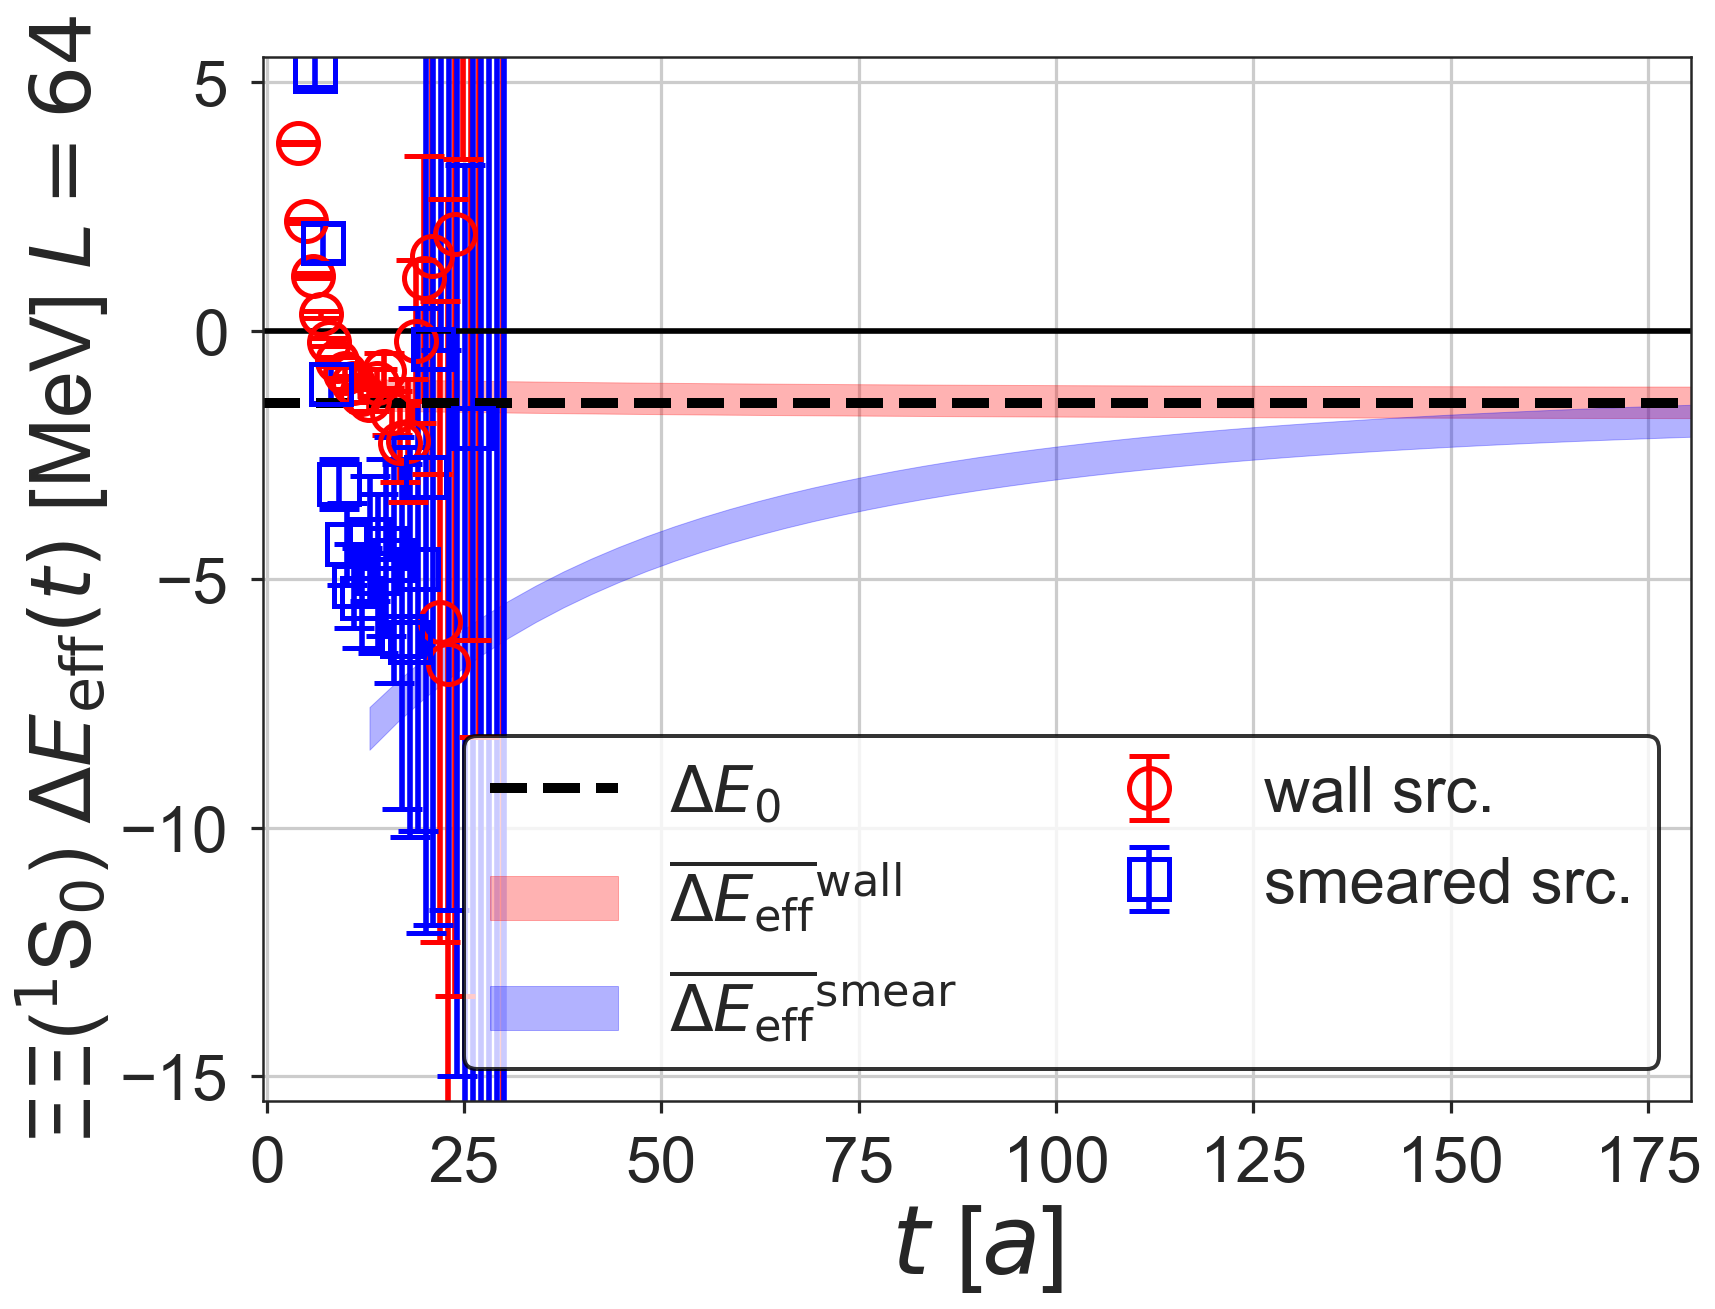

In [19]:
def plot_dEeff_with_ReEeff_large_t(L, it0 = 13):
    fig, ax = plt.subplots()
    ax.errorbar(dEeffs[(L,'wall')][:,0]-0.1, dEeffs[(L,'wall')][:,3]*ainv, dEeffs[(L,'wall')][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    ax.errorbar(dEeffs[(L,'exp')][:,0]+0.1, dEeffs[(L,'exp')][:,3]*ainv, dEeffs[(L,'exp')][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 185)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        ReEeff = eval_ReEeff(L, src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}$'.format({'wall':'wall','exp':'smear'}[src]))
        
    eigen_av = eigenvals[(L,it0)][:,0].mean()
    ax.axhline(eigen_av*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))

    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 180.5)
    ax.set_xticks([0, 25, 50, 75, 100, 125, 150, 175])
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(ncol=2, loc='lower right', frameon=True)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'$\Xi\Xi$($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/dEeffs/REdEeff_wall_vs_smear_{L}_large_t.pdf', bbox_inches='tight')

for L in [40, 48, 64]:
    plot_dEeff_with_ReEeff_large_t(L)

Next, we check the cutoff dependence of the reconstruction.

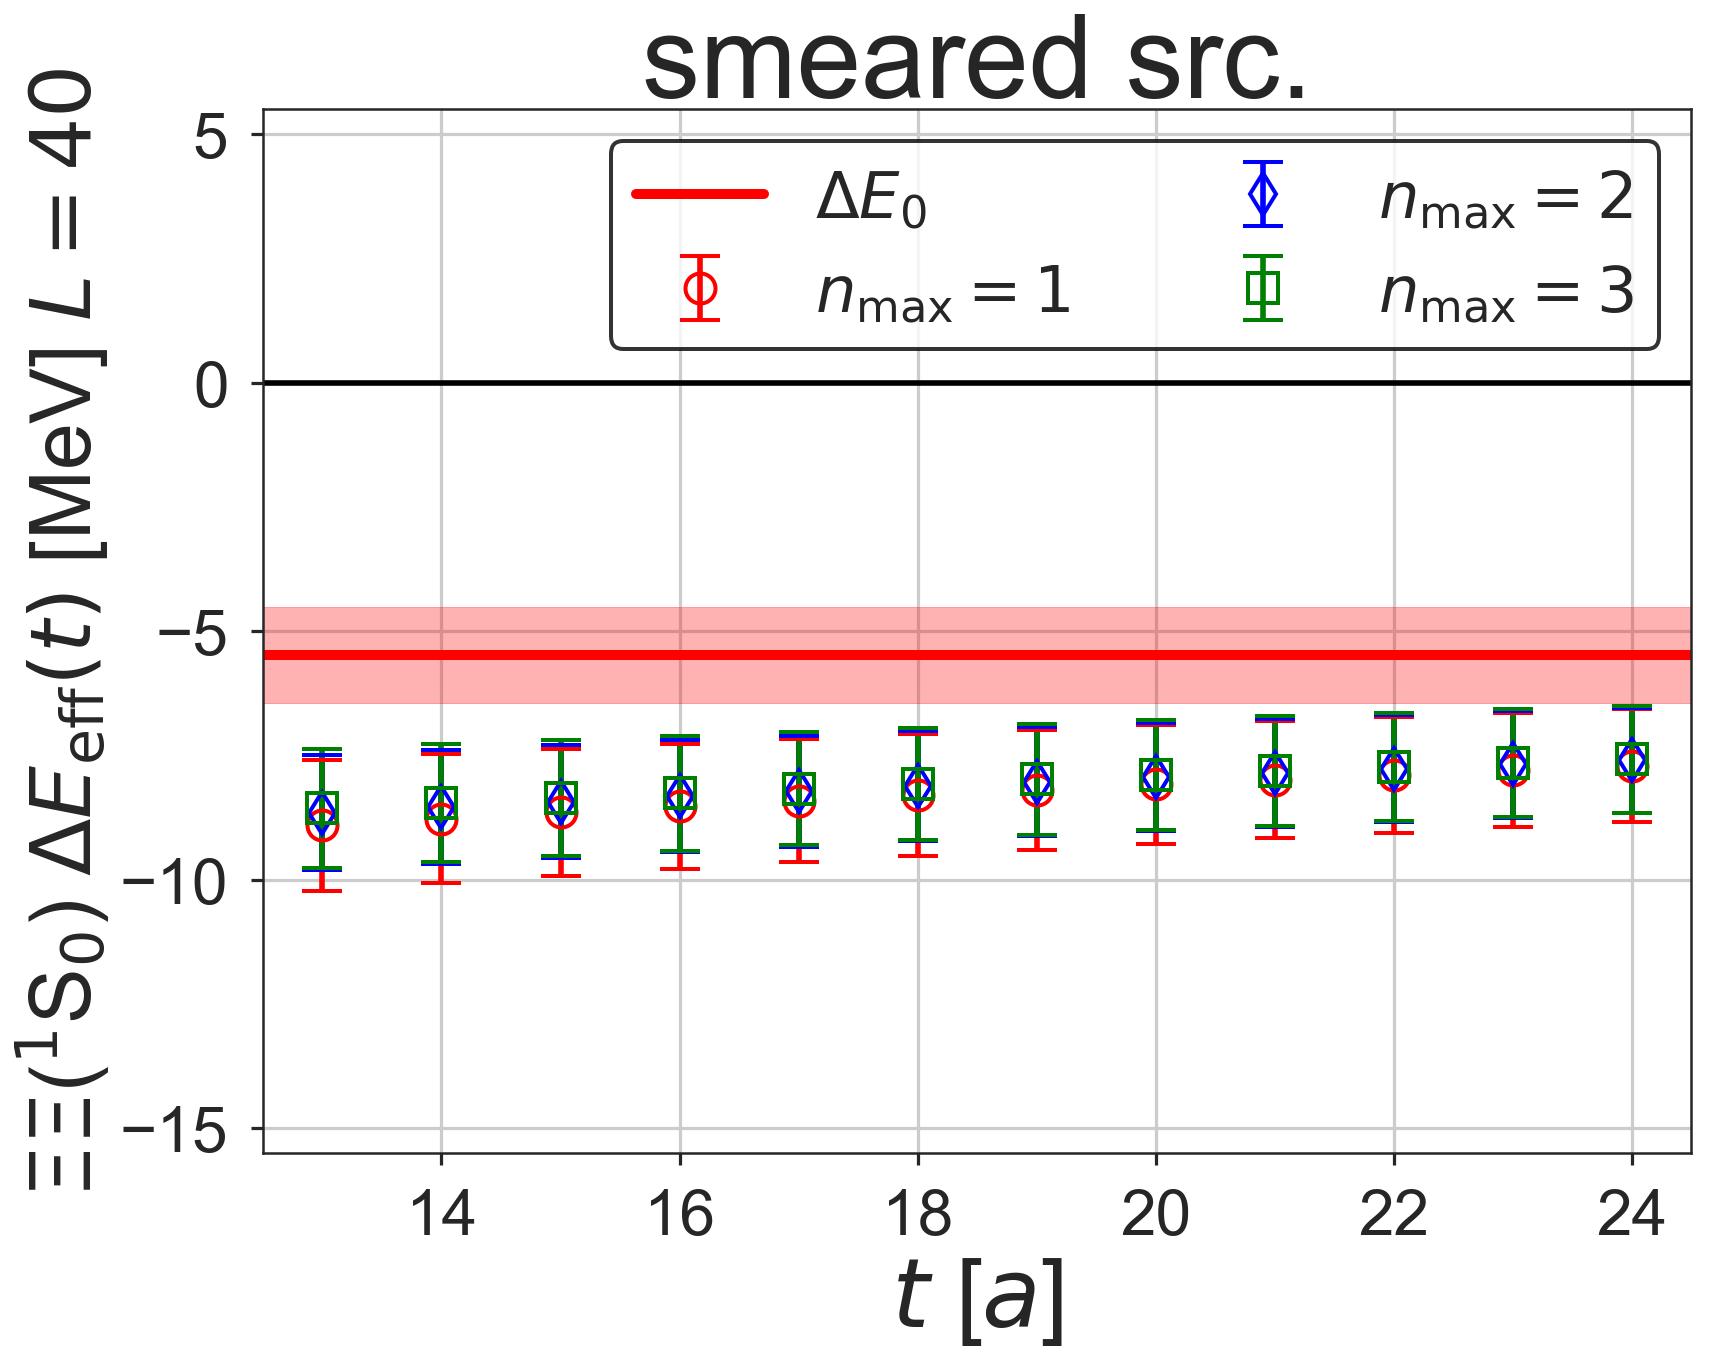

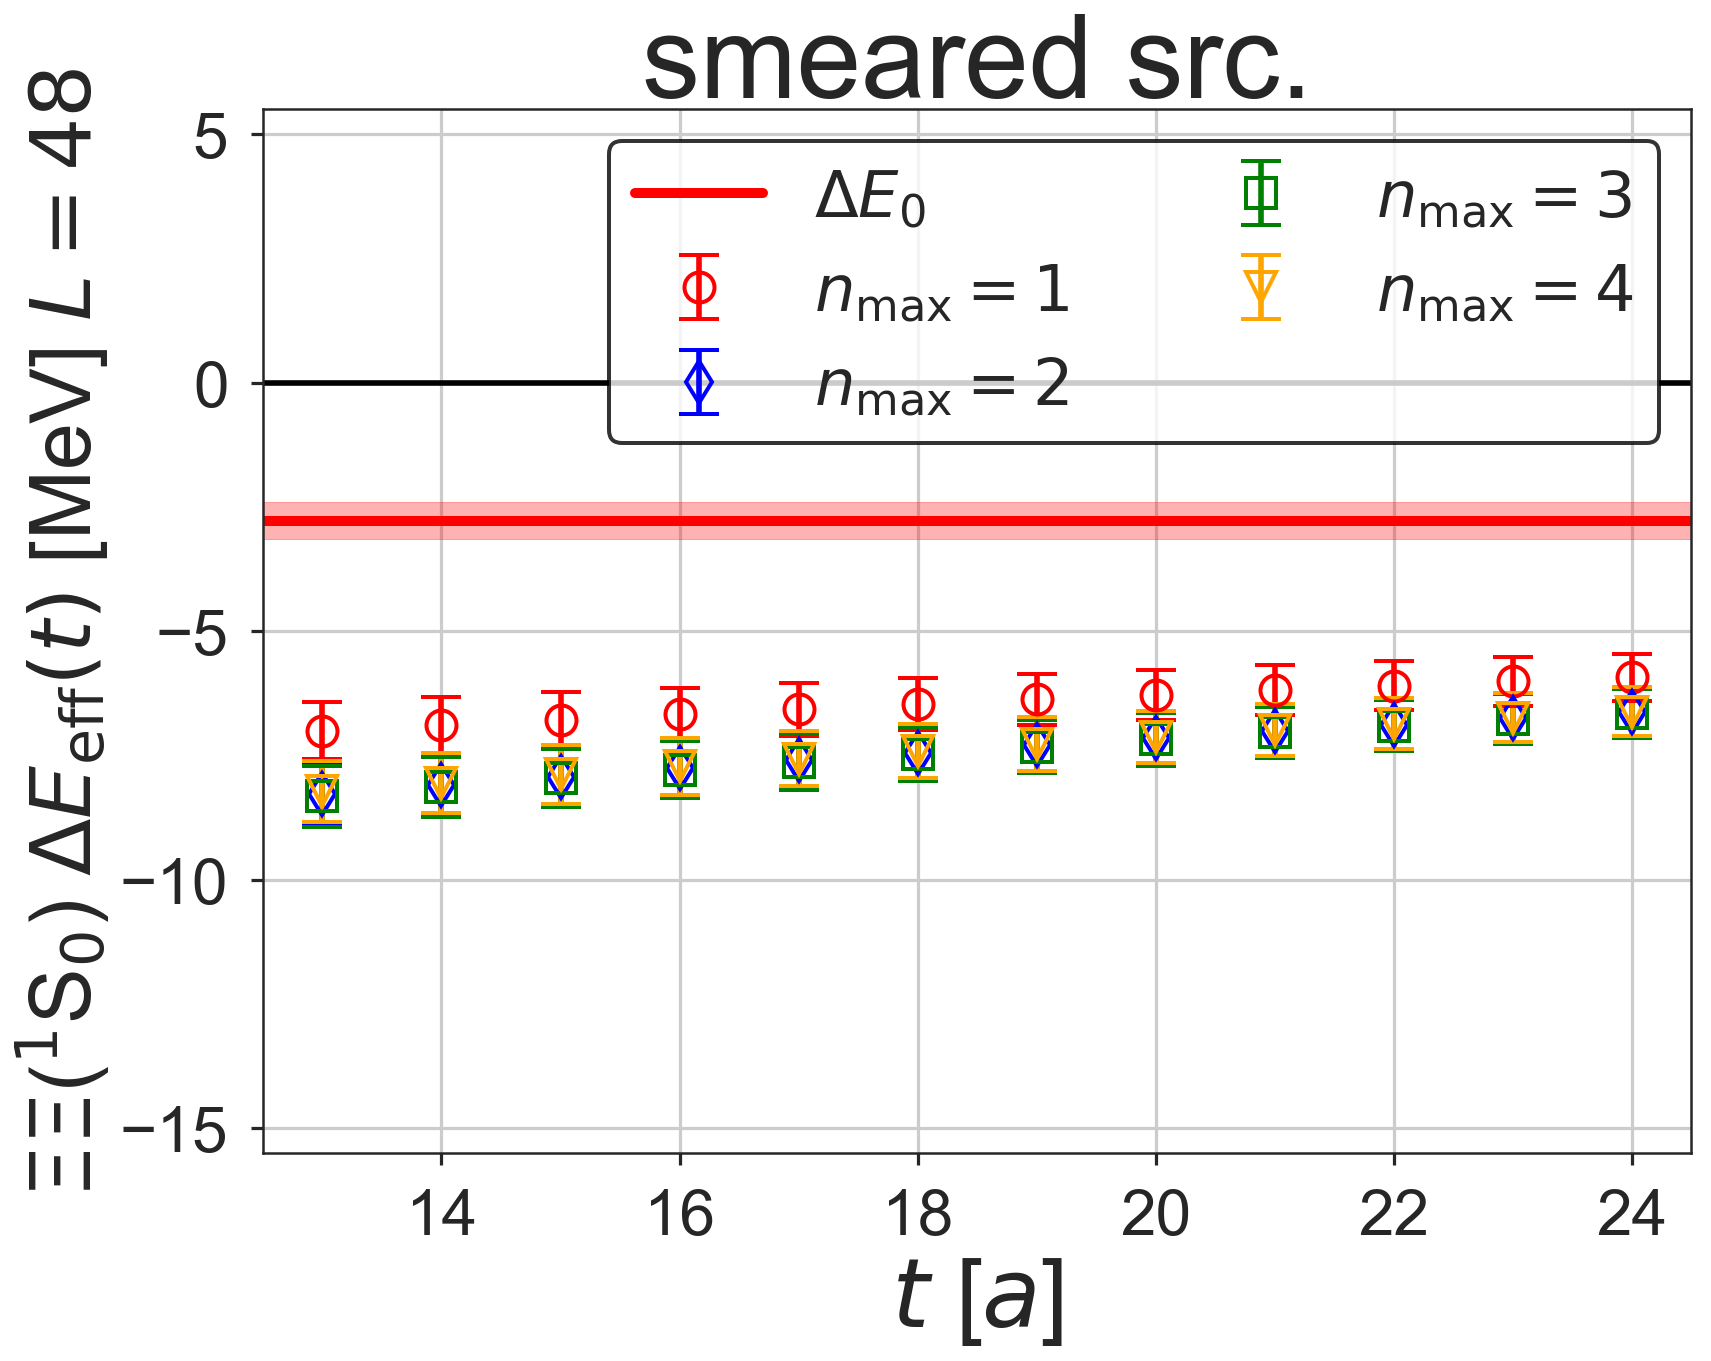

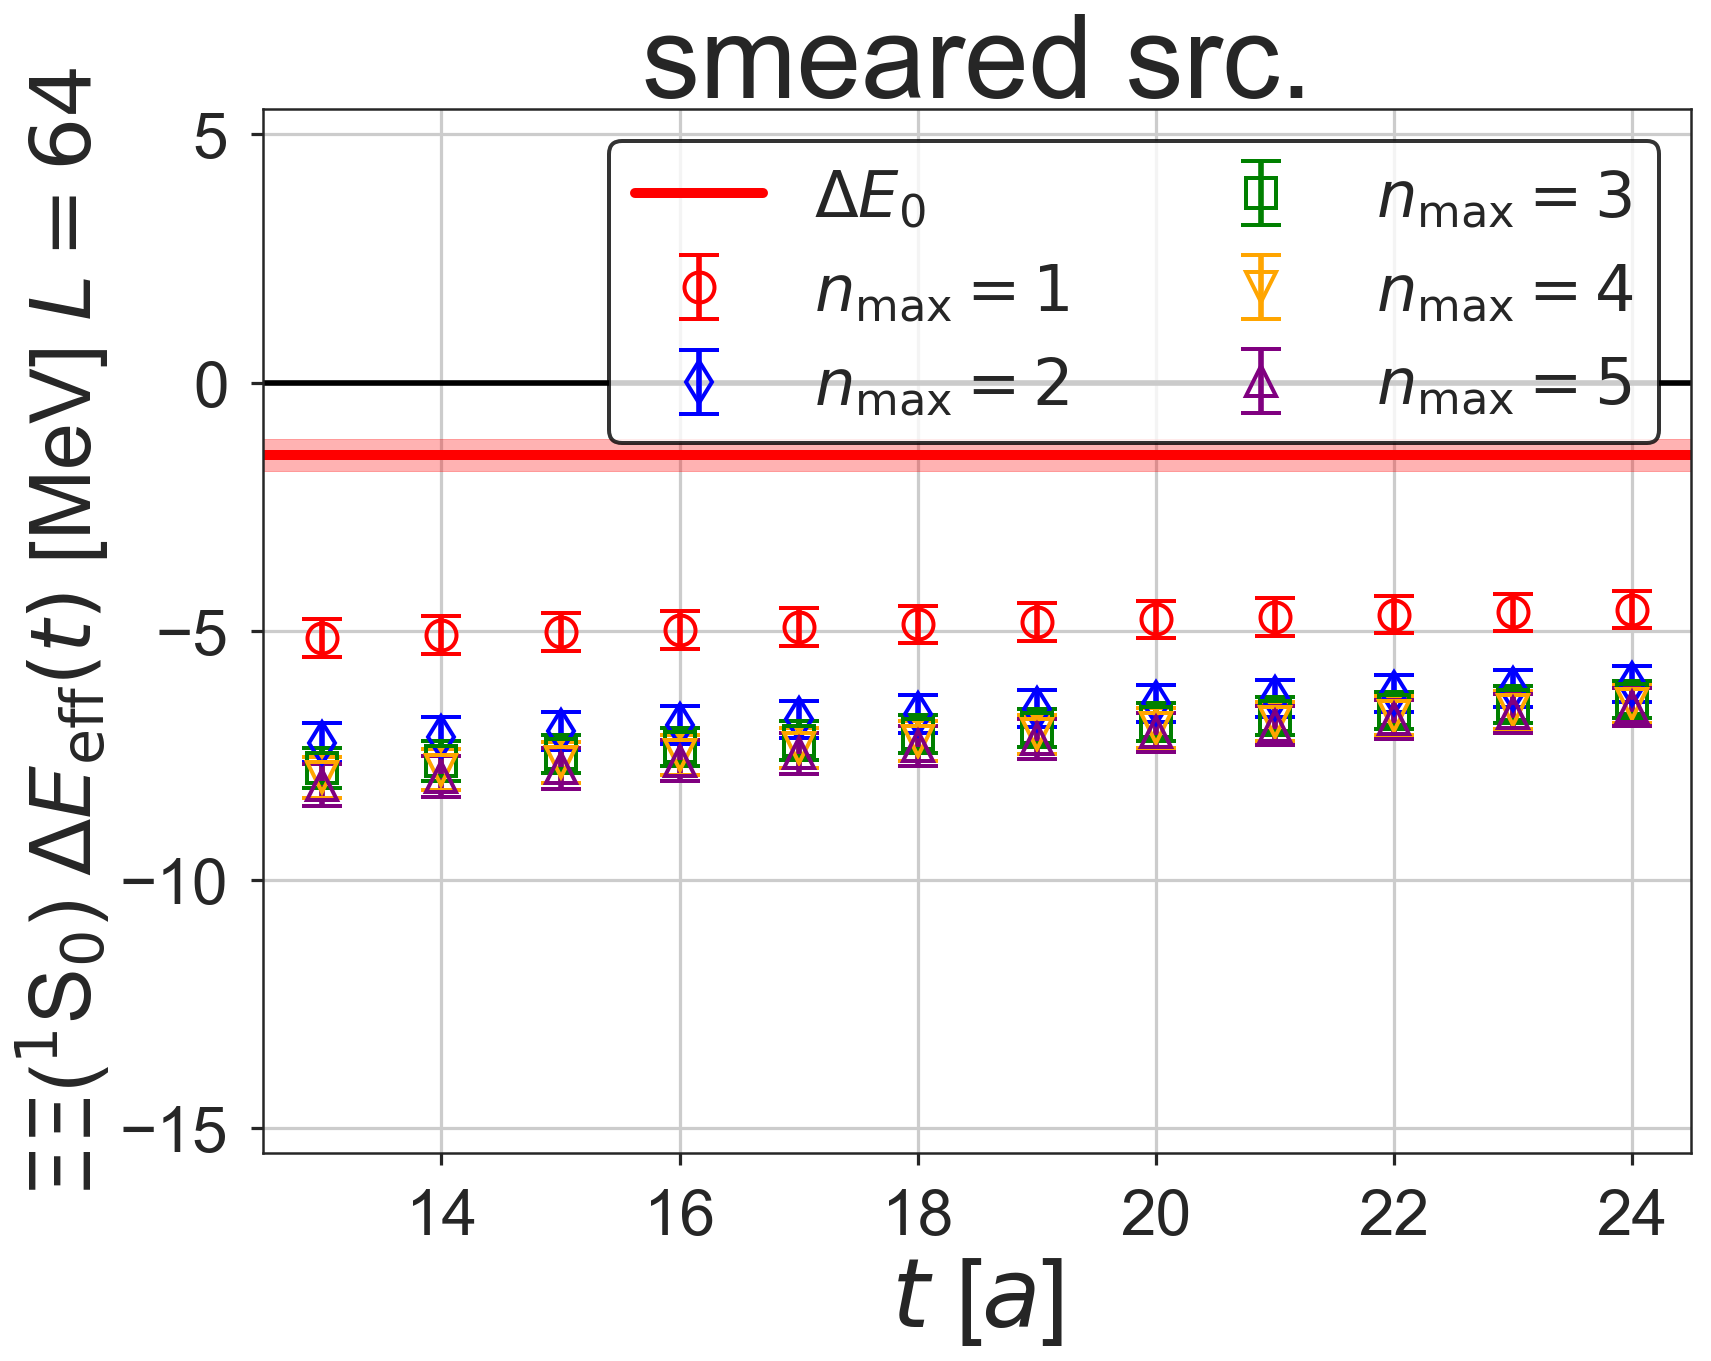

In [20]:
def plot_ReEeff_cutoff_dep(L, nmax=7, it0 = 13):
    fig, ax = plt.subplots()
    its = np.linspace(it0, 24)
    
    eigen_av = eigenvals[(L,it0)][:,0].mean()
    eigen_err = eigenvals[(L,it0)][:,0].std()*np.sqrt(bin_num - 1)
        
    ax.axhline(eigen_av*ainv, color='red', lw=5,
              label=r'$\Delta E_0$')
    ax.axhspan(
        (eigen_av+eigen_err)*ainv, 
        (eigen_av-eigen_err)*ainv, 
                       color='red', alpha=0.3)
    src = 'exp'
    its = np.arange(13, 25)
    for n, sym, col in zip(np.arange(2,7,1), ['o', 'd', 's', 'v', '^'],
                          ['red', 'blue', 'green', 'orange', 'purple']):
        
        if n == nmax:
            break
        eff = eval_ReEeff_w_cut(L, src, its, n)

        ax.errorbar(its, eff[:,0]*ainv, eff[:,1]*ainv, fmt=sym, color=col,
                    mfc='none', mew=2.0, capsize=10, capthick=2.0,
                   ms=15, label=rf'$n_\mathrm{{max}} = {n-1}$')

    ax.axhline(0, color='black')
    ax.set_xlim(12.5, 24.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='upper right', ncol=2, frameon=True)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')
    ax.set_title('smeared src.', fontsize=58)

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'$\Xi\Xi$($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/dEeffs/REdEeff_smear_cut_dep_{L}.pdf', bbox_inches='tight')


plot_ReEeff_cutoff_dep(40, nmax=5)
plot_ReEeff_cutoff_dep(48, nmax=6)
plot_ReEeff_cutoff_dep(64)